### This script runs some basic bhv analysis, and detailed analysis focus on the continuous behavioral variables

#### The output of this script will also be used by the DBN scripts

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import scipy
import string
import warnings
import pickle

import os
import glob
import random
from time import time


### function - get body part location for each pair of cameras

In [2]:
from ana_functions.body_part_locs_eachpair import body_part_locs_eachpair

### function - find social gaze time point

In [3]:
from ana_functions.find_socialgaze_timepoint import find_socialgaze_timepoint
from ana_functions.find_socialgaze_timepoint_Anipose import find_socialgaze_timepoint_Anipose
from ana_functions.find_socialgaze_timepoint_Anipose_2 import find_socialgaze_timepoint_Anipose_2

### function - define time point of behavioral events

In [4]:
from ana_functions.bhv_events_timepoint import bhv_events_timepoint
from ana_functions.bhv_events_timepoint_Anipose import bhv_events_timepoint_Anipose

### function - plot behavioral events

In [5]:
from ana_functions.plot_bhv_events import plot_bhv_events
from ana_functions.plot_bhv_events_levertube import plot_bhv_events_levertube
from ana_functions.tracking_video_Anipose_events_demo import tracking_video_Anipose_events_demo
from ana_functions.plot_continuous_bhv_var import plot_continuous_bhv_var
from ana_functions.draw_self_loop import draw_self_loop
import matplotlib.patches as mpatches 
from matplotlib.collections import PatchCollection

### function - interval between all behavioral events

In [6]:
from ana_functions.bhv_events_interval import bhv_events_interval

## Analyze each session

### prepare the basic behavioral data (especially the time stamps for each bhv events)

In [7]:
# gaze angle threshold
# angle_thres = np.pi/36 # 5 degree
# angle_thres = np.pi/18 # 10 degree
angle_thres = np.pi/12 # 15 degree
# angle_thres = np.pi/4 # 45 degree
# angle_thres = np.pi/6 # 30 degree
angle_thres_name = '15'

merge_campairs = ['_Anipose'] # "_Anipose": this script is only for Anipose 3d reconstruction of camera 1,2,3 

with_tubelever = 1 # 1: consider the location of tubes and levers, only works if using Anipose 3d (or single camera)

# get the fps of the analyzed video
fps = 30

# frame number of the demo video
# nframes = 1*30
nframes = 1

# re-analyze the video or not
reanalyze_video = 0
redo_anystep = 0

# only analyze the best (five) sessions for each conditions
do_bestsession = 1
if do_bestsession:
    savefile_sufix = '_bestsessions'
else:
    savefile_sufix = ''
    
# all the videos (no misaligned ones)
# aligned with the audio
# get the session start time from "videosound_bhv_sync.py/.ipynb"
# currently the session_start_time will be manually typed in. It can be updated after a better method is used

# dodson scorch
if 0:
    if not do_bestsession:
        dates_list = [
                      "20220909","20220912","20220915","20220920","20220922","20220923","20221010",
                      "20221011","20221013","20221014","20221015","20221017","20230215",     
                      "20221018","20221019","20221020","20221021","20221022","20221026","20221028","20221030",
                      "20221107","20221108","20221109","20221110","20221111","20221114","20221115","20221116",
                      "20221117","20221118","20221121","20221122","20221123","20221125","20221128","20221129",              
                      "20221205","20221206","20221209","20221212","20221214","20221216","20221219","20221220",
                      "20221221","20230208","20230209","20230213","20230214","20230111","20230112","20230201",

                     ]
        session_start_times = [ 
                                 6.50, 18.10, 0,      33.03, 549.0, 116.80, 6.50,
                                 2.80, 27.80, 272.50, 27.90, 27.00,  33.00,
                                28.70, 45.30, 21.10,  27.10, 51.90,  21.00, 30.80, 17.50,                      
                                15.70,  2.65, 27.30,   0.00,  0.00,  71.80,  0.00,  0.00, 
                                75.50, 20.20,  0.00,  24.20, 36.70,  26.40, 22.50, 28.50,                       
                                 0.00,  0.00, 21.70,  84.70, 17.00,  19.80, 23.50, 25.20,  
                                 0.00,  0.00,  0.00,   0.00,  0.00, 130.00, 14.20, 24.20, 
                              ] # in second
    elif do_bestsession:
        # pick only five sessions for each conditions
        dates_list = [
                      "20220912","20220915","20220920","20221010","20230208",
                      "20221011","20221013","20221015","20221017",
                      "20221022","20221026","20221028","20221030","20230209",
                      "20221125","20221128","20221129","20230214","20230215",                  
                      "20221205","20221206","20221209","20221214","20230112",
                      "20230117","20230118","20230124","20230126",
                     ]
        session_start_times = [ 
                                18.10,  0.00, 33.03,  6.50,  0.00, 
                                 2.80, 27.80, 27.90, 27.00,  
                                51.90, 21.00, 30.80, 17.50,  0.00,                    
                                26.40, 22.50, 28.50,  0.00, 33.00,                     
                                 0.00,  0.00, 21.70, 17.00, 14.20, 
                                 0.00,  0.00,  0.00,  0.00,  
                              ] # in second
    
    animal1_fixedorder = ['dodson']
    animal2_fixedorder = ['scorch']

    animal1_filename = "Dodson"
    animal2_filename = "Scorch"
    
# eddie sparkle
if 0:
    if not do_bestsession:
        dates_list = [
                      "20221122","20221125","20221128","20221129","20221130","20221202","20221206",
                      "20221207","20221208","20221209","20230126","20230127","20230130","20230201","20230203-1",
                      "20230206","20230207","20230208-1","20230209","20230222","20230223-1","20230227-1",
                      "20230228-1","20230302-1","20230307-2","20230313","20230315","20230316","20230317",
                      "20230321","20230322","20230324","20230327","20230328",
                      "20230330","20230331","20230403","20230404","20230405","20230406","20230407",
                      
                   ]
        session_start_times = [ 
                                 8.00,38.00,1.00,3.00,5.00,9.50,1.00,
                                 4.50,4.50,5.00,38.00,166.00,4.20,3.80,3.60,
                                 7.50,9.00,7.50,8.50,14.50,7.80,8.00,7.50,
                                 8.00,8.00,4.00,123.00,14.00,8.80,
                                 7.00,7.50,5.50,11.00,9.00,
                                 17.00,4.50,9.30,25.50,20.40,21.30,24.80,
                                 
                              ] # in second
    elif do_bestsession:   
        dates_list = [
                      "20221122",  "20221125",  
                      "20221202",  "20221206",  "20230126",  "20230130",  "20230201",
                      "20230207",  "20230208-1","20230209",  "20230222",  "20230223-1",
                      "20230227-1","20230228-1","20230302-1","20230307-2","20230313",
                      "20230321",  "20230322",  "20230324",  "20230327",  "20230328",
                      "20230331",  "20230403",  "20230404",  "20230405",  "20230406"
                   ]
        session_start_times = [ 
                                  8.00,  38.00, 
                                  9.50,   1.00, 38.00,  4.20,  3.80,
                                  9.00,   7.50,  8.50, 14.50,  7.80,
                                  8.00,   7.50,  8.00,  8.00,  4.00,
                                  7.00,   7.50,  5.50, 11.00,  9.00,
                                  4.50,   9.30, 25.50, 20.40, 21.30,
                              ] # in second
    
    animal1_fixedorder = ['eddie']
    animal2_fixedorder = ['sparkle']

    animal1_filename = "Eddie"
    animal2_filename = "Sparkle"
    
# ginger kanga
if 0:
    if not do_bestsession:
        dates_list = [
                      "20230209","20230213","20230214","20230216","20230222","20230223","20230228","20230302",
                      "20230303","20230307","20230314","20230315","20230316","20230317"         
                   ]
        session_start_times = [ 
                                 0.00,  0.00,  0.00, 48.00, 26.20, 18.00, 23.00, 28.50,
                                34.00, 25.50, 25.50, 31.50, 28.00, 30.50
                              ] # in second 
    elif do_bestsession:   
        dates_list = [
                      "20230213", # camera2 is set up wrong
                      "20230214","20230216",
                      "20230228","20230302","20230303","20230307",          
                      "20230314","20230315","20230316","20230317",
                      "20230301","20230320","20230321","20230322",
                      "20230323","20230412","20230413","20230517","20230614","20230615",
                      "20230522_ws","20230524","20230605_1","20230606","20230607"
                   ]
        session_start_times = [ 
                                 0.00, # camera2 is set up wrong
                                 0.00, 48.00, 
                                23.00, 28.50, 34.00, 25.50, 
                                25.50, 31.50, 28.00, 30.50,
                                33.50, 22.20, 50.00,  0.00, 
                                33.00, 18.20, 22.80, 31.00, 24.00, 21.00,
                                 0.00,  0.00,  0.00,  0.00,  0.00,
                              ] # in second 
    
    animal1_fixedorder = ['ginger']
    animal2_fixedorder = ['kanga']

    animal1_filename = "Ginger"
    animal2_filename = "Kanga"

# dannon kanga
if 1:
    if not do_bestsession:
        dates_list = [
                      "20230718","20230720","20230914","20230829","20230907","20230915",
                      "20230918","20230926","20230928","20231002","20231010","20231011",
                      "20231013",
                   ]
        session_start_times = [ 
                                 0, 0, 0, 0, 0, 0, 
                                 0, 0, 0, 0, 0, 0,
                                 0, 0, 0, 0, 
                              ] # in second 
    elif do_bestsession:   
        dates_list = [
                      "20230718","20230720","20230914","20230726","20230727","20230809",
                      "20230810","20230811","20230814","20230816","20230829","20230907","20230915",
                      "20230918","20230926","20230928","20231002","20231010","20231011",
                      "20231013","20231020","20231024","20231025",
                   ]
        session_start_times = [ 
                                    0,    0,    0, 32.2, 27.2, 37.5,
                                 21.0, 21.5, 19.8, 32.0,    0,    0,   0, 
                                    0,    0,    0,    0,    0,    0,
                                    0,    0,    0,    0, 
                              ] # in second 
    
    animal1_fixedorder = ['dannon']
    animal2_fixedorder = ['kanga']

    animal1_filename = "Dannon"
    animal2_filename = "Kanga"
    
    
# Koala Vermelho
if 0:
    if not do_bestsession:
        dates_list = [
                      "20231221","20231222","20231226","20231227",  "20231229","20231230",
                      "20231231","20240102","20240104","20240104-2","20240105","20240108",
                      "20240109","20240115","20240116","20240117",  "20240118","20240119",
                      "20240122","20240123","20240124","20240125",  "20240126","20240129",
                      "20240130","20240131","20240201","20240202",  
                     ]
        session_start_times = [ 
                                0.00,  0.00,  0.00,  0.00,  0.00,  0.00, 
                                0.00,  0.00,  0.00,  0.00,  0.00,  0.00, 
                                0.00,  0.00,  0.00,  0.00,  0.00,  0.00,
                                0.00,  0.00,  0.00,  0.00,  0.00,  0.00,
                                0.00,  0.00,  0.00,  0.00,
                              ] # in second
    elif do_bestsession:
        # pick only five sessions for each conditions
        dates_list = [
                      "20231222","20231226","20231227",  "20231229","20231230",
                      "20231231","20240102","20240104-2","20240105","20240108",
                      "20240109","20240115","20240116",  "20240117","20240118","20240119",
                      "20240207","20240208","20240209",  "20240212","20240213",
                      "20240214","20240215","20240216",  "20240220","20240222","20240223",
                     ]
        session_start_times = [ 
                                21.5,  0.00,  0.00,  0.00,  0.00, 
                                0.00,  12.2,  0.00,  18.8,  31.2,  
                                32.5,  0.00,  50.0,  0.00,  37.5,  29.5,
                                58.5,  72.0,  0.00,  71.5,  70.5,
                                86.8,  94.0,  65.0,  68.8,  43.8,  13.2,
                              ] # in second
    
    animal1_fixedorder = ['koala']
    animal2_fixedorder = ['vermelho']

    animal1_filename = "Koala"
    animal2_filename = "Vermelho"
    
    

# a test case
if 0:
    dates_list = ["20230324"]
    session_start_times = [5.50] # in second
    animal1_fixedorder = ['eddie']
    animal2_fixedorder = ['sparkle']
    animal1_filename = "Eddie"
    animal2_filename = "Sparkle"

ndates = np.shape(dates_list)[0]

session_start_frames = session_start_times * fps # fps is 30Hz

totalsess_time = 600

if np.shape(session_start_times)[0] != np.shape(dates_list)[0]:
    exit()    
    
# define bhv events summarizing variables     
tasktypes_all_dates = np.zeros((ndates,1))
coopthres_all_dates = np.zeros((ndates,1))

succ_rate_all_dates = np.zeros((ndates,1))
interpullintv_all_dates = np.zeros((ndates,1))
trialnum_all_dates = np.zeros((ndates,1))

# switch animals to make animal 1 and 2 consistent
owgaze1_num_all_dates = np.zeros((ndates,1))
owgaze2_num_all_dates = np.zeros((ndates,1))
mtgaze1_num_all_dates = np.zeros((ndates,1))
mtgaze2_num_all_dates = np.zeros((ndates,1))
pull1_num_all_dates = np.zeros((ndates,1))
pull2_num_all_dates = np.zeros((ndates,1))

bhv_intv_all_dates = dict.fromkeys(dates_list, [])
pull_trig_events_all_dates = dict.fromkeys(dates_list, [])
pull_trig_events_succtrials_all_dates = dict.fromkeys(dates_list, [])
pull_trig_events_errtrials_all_dates = dict.fromkeys(dates_list, [])


# video tracking results info
animalnames_videotrack = ['dodson','scorch'] # does not really mean dodson and scorch, instead, indicate animal1 and animal2
bodypartnames_videotrack = ['rightTuft','whiteBlaze','leftTuft','rightEye','leftEye','mouth']

# where to save the summarizing data
data_saved_folder = '/gpfs/gibbs/pi/jadi/VideoTracker_SocialInter/3d_recontruction_analysis_self_and_coop_task_data_saved/'

# where to save the demo video
withboxCorner = 1
video_file_dir = data_saved_folder+'/example_videos_Anipose_bhv_demo/'+animal1_filename+'_'+animal2_filename
if not os.path.exists(video_file_dir):
    os.makedirs(video_file_dir)

    


In [8]:
# basic behavior analysis (define time stamps for each bhv events, etc)
# NOTE: THIS STEP will save the data to the combinedsession_Anipose folder, since they are the same
try:
    if redo_anystep:
        dummy
    # dummy
    
    data_saved_subfolder = data_saved_folder+'data_saved_combinedsessions_Anipose'+savefile_sufix+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    with open(data_saved_subfolder+'/owgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        owgaze1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/owgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        owgaze2_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/mtgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        mtgaze1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/mtgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        mtgaze2_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        pull1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        pull2_num_all_dates = pickle.load(f)

    with open(data_saved_subfolder+'/tasktypes_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        tasktypes_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/coopthres_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        coopthres_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/succ_rate_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        succ_rate_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/interpullintv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        interpullintv_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/trialnum_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        trialnum_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/bhv_intv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        bhv_intv_all_dates = pickle.load(f)
        
    with open(data_saved_subfolder+'/pull_trig_events_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        pull_trig_events_all_dates = pickle.load(f) 
    with open(data_saved_subfolder+'/pull_trig_events_succtrials_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        pull_trig_events_succtrials_all_dates = pickle.load(f) 
    with open(data_saved_subfolder+'/pull_trig_events_errtrials_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        pull_trig_events_errtrials_all_dates = pickle.load(f) 
    

        
except:

    for idate in np.arange(0,ndates,1):
        date_tgt = dates_list[idate]
        session_start_time = session_start_times[idate]

        # folder path
        camera12_analyzed_path = "/gpfs/gibbs/pi/jadi/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera12/"
        camera23_analyzed_path = "/gpfs/gibbs/pi/jadi/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera23/"
        Anipose_analyzed_path = "/gpfs/gibbs/pi/jadi/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera12/anipose_cam123_3d_h5_files/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"

        for imergepair in np.arange(0,np.shape(merge_campairs)[0],1):
            
            # should be only one merge type - "Anipose"
            merge_campair = merge_campairs[imergepair]

            # load camera tracking results
            try:
                # dummy
                if reanalyze_video:
                    print("re-analyze the data ",date_tgt)
                    dummy
                ## read
                with open(Anipose_analyzed_path + 'body_part_locs_Anipose.pkl', 'rb') as f:
                    body_part_locs_Anipose = pickle.load(f)                 
            except:
                print("did not save data for Anipose - body part tracking "+date_tgt)
                # analyze and save
                Anipose_h5_file = Anipose_analyzed_path +date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_anipose.h5"
                Anipose_h5_data = pd.read_hdf(Anipose_h5_file)
                body_part_locs_Anipose = body_part_locs_eachpair(Anipose_h5_data)
                with open(Anipose_analyzed_path + 'body_part_locs_Anipose.pkl', 'wb') as f:
                    pickle.dump(body_part_locs_Anipose, f)            
            
            min_length = np.min(list(body_part_locs_Anipose.values())[0].shape[0])
                    
            # load behavioral results
            try:
                try:
                    bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
                    trial_record_json = glob.glob(bhv_data_path +date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_TrialRecord_" + "*.json")
                    bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_bhv_data_" + "*.json")
                    session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_session_info_" + "*.json")
                    #
                    trial_record = pd.read_json(trial_record_json[0])
                    bhv_data = pd.read_json(bhv_data_json[0])
                    session_info = pd.read_json(session_info_json[0])
                except:
                    bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
                    trial_record_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_TrialRecord_" + "*.json")
                    bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_bhv_data_" + "*.json")
                    session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_session_info_" + "*.json")
                    #
                    trial_record = pd.read_json(trial_record_json[0])
                    bhv_data = pd.read_json(bhv_data_json[0])
                    session_info = pd.read_json(session_info_json[0])
            except:
                try:
                    bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_forceManipulation_task/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
                    trial_record_json = glob.glob(bhv_data_path +date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_TrialRecord_" + "*.json")
                    bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_bhv_data_" + "*.json")
                    session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_session_info_" + "*.json")
                    #
                    trial_record = pd.read_json(trial_record_json[0])
                    bhv_data = pd.read_json(bhv_data_json[0])
                    session_info = pd.read_json(session_info_json[0])
                except:
                    bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_forceManipulation_task/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
                    trial_record_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_TrialRecord_" + "*.json")
                    bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_bhv_data_" + "*.json")
                    session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_session_info_" + "*.json")
                    #
                    trial_record = pd.read_json(trial_record_json[0])
                    bhv_data = pd.read_json(bhv_data_json[0])
                    session_info = pd.read_json(session_info_json[0])

            # get animal info
            animal1 = session_info['lever1_animal'][0].lower()
            animal2 = session_info['lever2_animal'][0].lower()

            # get task type and cooperation threshold
            try:
                coop_thres = session_info["pulltime_thres"][0]
                tasktype = session_info["task_type"][0]
            except:
                coop_thres = 0
                tasktype = 1
            tasktypes_all_dates[idate] = tasktype
            coopthres_all_dates[idate] = coop_thres   

            # successful trial or not
            succtrial_ornot = np.array((trial_record['rewarded']>0).astype(int))
            succpull1_ornot = np.array((np.isin(bhv_data[bhv_data['behavior_events']==1]['trial_number'],trial_record[trial_record['rewarded']>0]['trial_number'])).astype(int))
            succpull2_ornot = np.array((np.isin(bhv_data[bhv_data['behavior_events']==2]['trial_number'],trial_record[trial_record['rewarded']>0]['trial_number'])).astype(int))
            succpulls_ornot = [succpull1_ornot,succpull2_ornot]
            
            # clean up the trial_record
            warnings.filterwarnings('ignore')
            trial_record_clean = pd.DataFrame(columns=trial_record.columns)
            for itrial in np.arange(0,np.max(trial_record['trial_number']),1):
                # trial_record_clean.loc[itrial] = trial_record[trial_record['trial_number']==itrial+1].iloc[[0]]
                trial_record_clean = trial_record_clean.append(trial_record[trial_record['trial_number']==itrial+1].iloc[[0]])
            trial_record_clean = trial_record_clean.reset_index(drop = True)

            # change bhv_data time to the absolute time
            time_points_new = pd.DataFrame(np.zeros(np.shape(bhv_data)[0]),columns=["time_points_new"])
            for itrial in np.arange(0,np.max(trial_record_clean['trial_number']),1):
                ind = bhv_data["trial_number"]==itrial+1
                new_time_itrial = bhv_data[ind]["time_points"] + trial_record_clean["trial_starttime"].iloc[itrial]
                time_points_new["time_points_new"][ind] = new_time_itrial
            bhv_data["time_points"] = time_points_new["time_points_new"]
            bhv_data = bhv_data[bhv_data["time_points"] != 0]


            # analyze behavior results
            # succ_rate_all_dates[idate] = np.sum(trial_record_clean["rewarded"]>0)/np.shape(trial_record_clean)[0]
            succ_rate_all_dates[idate] = np.sum((bhv_data['behavior_events']==3)|(bhv_data['behavior_events']==4))/np.sum((bhv_data['behavior_events']==1)|(bhv_data['behavior_events']==2))

            trialnum_all_dates[idate] = np.shape(trial_record_clean)[0]
            #
            pullid = np.array(bhv_data[(bhv_data['behavior_events']==1) | (bhv_data['behavior_events']==2)]["behavior_events"])
            pulltime = np.array(bhv_data[(bhv_data['behavior_events']==1) | (bhv_data['behavior_events']==2)]["time_points"])
            pullid_diff = np.abs(pullid[1:] - pullid[0:-1])
            pulltime_diff = pulltime[1:] - pulltime[0:-1]
            interpull_intv = pulltime_diff[pullid_diff==1]
            interpull_intv = interpull_intv[interpull_intv<10]
            mean_interpull_intv = np.nanmean(interpull_intv)
            std_interpull_intv = np.nanstd(interpull_intv)
            #
            interpullintv_all_dates[idate] = mean_interpull_intv

            if np.isin(animal1,animal1_fixedorder):
                pull1_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==1) 
                pull2_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==2)
            else:
                pull1_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==2)
                pull2_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==1) 
                
            # load behavioral event results
            try:
                # dummy
                print('load social gaze with Anipose 3d of '+date_tgt)
                with open(data_saved_folder+"bhv_events_Anipose/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+date_tgt+'/output_look_ornot.pkl', 'rb') as f:
                    output_look_ornot = pickle.load(f)
                with open(data_saved_folder+"bhv_events_Anipose/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+date_tgt+'/output_allvectors.pkl', 'rb') as f:
                    output_allvectors = pickle.load(f)
                with open(data_saved_folder+"bhv_events_Anipose/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+date_tgt+'/output_allangles.pkl', 'rb') as f:
                    output_allangles = pickle.load(f)  
                with open(data_saved_folder+"bhv_events_Anipose/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+date_tgt+'/output_key_locations.pkl', 'rb') as f:
                    output_key_locations = pickle.load(f)
            except:
                print('analyze social gaze with Anipose 3d only of '+date_tgt)
                # get social gaze information 
                output_look_ornot, output_allvectors, output_allangles = find_socialgaze_timepoint_Anipose(body_part_locs_Anipose,min_length,angle_thres,with_tubelever)
                output_key_locations = find_socialgaze_timepoint_Anipose_2(body_part_locs_Anipose,min_length,angle_thres,with_tubelever)
               
                # save data
                current_dir = data_saved_folder+'/bhv_events_Anipose/'+animal1_fixedorder[0]+animal2_fixedorder[0]
                add_date_dir = os.path.join(current_dir+'/'+date_tgt)
                if not os.path.exists(add_date_dir):
                    os.makedirs(add_date_dir)
                #
                with open(data_saved_folder+"bhv_events_Anipose/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+date_tgt+'/output_look_ornot.pkl', 'wb') as f:
                    pickle.dump(output_look_ornot, f)
                with open(data_saved_folder+"bhv_events_Anipose/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+date_tgt+'/output_allvectors.pkl', 'wb') as f:
                    pickle.dump(output_allvectors, f)
                with open(data_saved_folder+"bhv_events_Anipose/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+date_tgt+'/output_allangles.pkl', 'wb') as f:
                    pickle.dump(output_allangles, f)
                with open(data_saved_folder+"bhv_events_Anipose/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+date_tgt+'/output_key_locations.pkl', 'wb') as f:
                    pickle.dump(output_key_locations, f)
                
             
            look_at_face_or_not_Anipose = output_look_ornot['look_at_face_or_not_Anipose']
            look_at_selftube_or_not_Anipose = output_look_ornot['look_at_selftube_or_not_Anipose']
            look_at_selflever_or_not_Anipose = output_look_ornot['look_at_selflever_or_not_Anipose']
            look_at_othertube_or_not_Anipose = output_look_ornot['look_at_othertube_or_not_Anipose']
            look_at_otherlever_or_not_Anipose = output_look_ornot['look_at_otherlever_or_not_Anipose']
            # change the unit to second
            session_start_time = session_start_times[idate]
            look_at_face_or_not_Anipose['time_in_second'] = np.arange(0,np.shape(look_at_face_or_not_Anipose['dodson'])[0],1)/fps - session_start_time
            look_at_selflever_or_not_Anipose['time_in_second'] = np.arange(0,np.shape(look_at_selflever_or_not_Anipose['dodson'])[0],1)/fps - session_start_time
            look_at_selftube_or_not_Anipose['time_in_second'] = np.arange(0,np.shape(look_at_selftube_or_not_Anipose['dodson'])[0],1)/fps - session_start_time 
            look_at_otherlever_or_not_Anipose['time_in_second'] = np.arange(0,np.shape(look_at_otherlever_or_not_Anipose['dodson'])[0],1)/fps - session_start_time
            look_at_othertube_or_not_Anipose['time_in_second'] = np.arange(0,np.shape(look_at_othertube_or_not_Anipose['dodson'])[0],1)/fps - session_start_time 

            look_at_Anipose = {"face":look_at_face_or_not_Anipose,"selflever":look_at_selflever_or_not_Anipose,
                               "selftube":look_at_selftube_or_not_Anipose,"otherlever":look_at_otherlever_or_not_Anipose,
                               "othertube":look_at_othertube_or_not_Anipose} 
            
            # find time point of behavioral events
            output_time_points_socialgaze ,output_time_points_levertube = bhv_events_timepoint_Anipose(bhv_data,look_at_Anipose)
            time_point_pull1 = output_time_points_socialgaze['time_point_pull1']
            time_point_pull2 = output_time_points_socialgaze['time_point_pull2']
            oneway_gaze1 = output_time_points_socialgaze['oneway_gaze1']
            oneway_gaze2 = output_time_points_socialgaze['oneway_gaze2']
            mutual_gaze1 = output_time_points_socialgaze['mutual_gaze1']
            mutual_gaze2 = output_time_points_socialgaze['mutual_gaze2']
            timepoint_lever1 = output_time_points_levertube['time_point_lookatlever1']   
            timepoint_lever2 = output_time_points_levertube['time_point_lookatlever2']   
            timepoint_tube1 = output_time_points_levertube['time_point_lookattube1']   
            timepoint_tube2 = output_time_points_levertube['time_point_lookattube2']   
                
            # # plot behavioral events
            if 0:
                if np.isin(animal1,animal1_fixedorder):
                    plot_bhv_events_levertube(date_tgt+merge_campair,animal1, animal2, session_start_time, totalsess_time, 
                                              time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2,
                                              timepoint_lever1,timepoint_lever2,timepoint_tube1,timepoint_tube2)
                else:
                    plot_bhv_events_levertube(date_tgt+merge_campair,animal2, animal1, session_start_time, totalsess_time, 
                                              time_point_pull2, time_point_pull1, oneway_gaze2, oneway_gaze1, mutual_gaze2, mutual_gaze1,
                                              timepoint_lever2,timepoint_lever1,timepoint_tube2,timepoint_tube1)
            #
            # save behavioral events plot
            if 0:
                current_dir = data_saved_folder+'/bhv_events_Anipose/'+animal1_fixedorder[0]+animal2_fixedorder[0]
                add_date_dir = os.path.join(current_dir+'/'+date_tgt)
                if not os.path.exists(add_date_dir):
                    os.makedirs(add_date_dir)
                plt.savefig(data_saved_folder+"bhv_events_Anipose/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+date_tgt+'/'+date_tgt+"_Anipose.pdf")
  
            #
            # # old definition
            # if np.isin(animal1,animal1_fixedorder):
            #     owgaze1_num_all_dates[idate] = np.shape(oneway_gaze1)[0]
            #     owgaze2_num_all_dates[idate] = np.shape(oneway_gaze2)[0]
            #     mtgaze1_num_all_dates[idate] = np.shape(mutual_gaze1)[0]
            #     mtgaze2_num_all_dates[idate] = np.shape(mutual_gaze2)[0]
            # else:
            #     owgaze1_num_all_dates[idate] = np.shape(oneway_gaze2)[0]
            #     owgaze2_num_all_dates[idate] = np.shape(oneway_gaze1)[0]
            #     mtgaze1_num_all_dates[idate] = np.shape(mutual_gaze2)[0]
            #     mtgaze2_num_all_dates[idate] = np.shape(mutual_gaze1)[0]
            #
            # new defnition
            # <500ms counts as one gaze, gaze number per second
            if np.isin(animal1,animal1_fixedorder):
                owgaze1_num_all_dates[idate] = np.sum(oneway_gaze1[1:]-oneway_gaze1[:-1]>=0.5)/(min_length/fps)
                owgaze2_num_all_dates[idate] = np.sum(oneway_gaze2[1:]-oneway_gaze2[:-1]>=0.5)/(min_length/fps)
                mtgaze1_num_all_dates[idate] = np.sum(mutual_gaze1[1:]-mutual_gaze1[:-1]>=0.5)/(min_length/fps)
                mtgaze2_num_all_dates[idate] = np.sum(mutual_gaze2[1:]-mutual_gaze2[:-1]>=0.5)/(min_length/fps)
            else:
                owgaze1_num_all_dates[idate] = np.sum(oneway_gaze2[1:]-oneway_gaze2[:-1]>=0.5)/(min_length/fps)
                owgaze2_num_all_dates[idate] = np.sum(oneway_gaze1[1:]-oneway_gaze1[:-1]>=0.5)/(min_length/fps)
                mtgaze1_num_all_dates[idate] = np.sum(mutual_gaze2[1:]-mutual_gaze2[:-1]>=0.5)/(min_length/fps)
                mtgaze2_num_all_dates[idate] = np.sum(mutual_gaze1[1:]-mutual_gaze1[:-1]>=0.5)/(min_length/fps)
            
            
            # plot key continuous behavioral variables
            if 1:
                filepath_cont_var = data_saved_folder+'bhv_events_continuous_variables_Anipose/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'+date_tgt+'/'
                if not os.path.exists(filepath_cont_var):
                    os.makedirs(filepath_cont_var)
                
                savefig = 1
                pull_trig_events_summary, pull_trig_events_succtrial_summary, pull_trig_events_errtrial_summary = plot_continuous_bhv_var(filepath_cont_var+date_tgt+merge_campair,savefig, animal1, animal2, 
                                        session_start_time, min_length,succpulls_ornot,
                                        time_point_pull1, time_point_pull2,animalnames_videotrack,
                                        output_look_ornot, output_allvectors, output_allangles,output_key_locations)
                pull_trig_events_all_dates[date_tgt] = pull_trig_events_summary
                pull_trig_events_succtrials_all_dates[date_tgt] = pull_trig_events_succtrial_summary
                pull_trig_events_errtrials_all_dates[date_tgt] = pull_trig_events_errtrial_summary
                    
                
            # analyze the events interval, especially for the pull to other and other to pull interval
            # could be used for define time bin for DBN
            if 1:
                _,_,_,pullTOother_itv, otherTOpull_itv = bhv_events_interval(totalsess_time, session_start_time, time_point_pull1, time_point_pull2, 
                                                                             oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
                #
                pull_other_pool_itv = np.concatenate((pullTOother_itv,otherTOpull_itv))
                bhv_intv_all_dates[date_tgt] = {'pull_to_other':pullTOother_itv,'other_to_pull':otherTOpull_itv,
                                'pull_other_pooled': pull_other_pool_itv}
        
        
            
            # plot the tracking demo video
            if 0:      
                video_file = video_file_dir+'/'+date_tgt+'_'+animal1_filename+'_'+animal2_filename+'_anipose_bhv_demo.mp4'
                tracking_video_Anipose_events_demo(body_part_locs_Anipose,output_look_ornot,output_allvectors,output_allangles,
                                                   time_point_pull1,time_point_pull2,animalnames_videotrack,bodypartnames_videotrack,
                                                   date_tgt,animal1_filename,animal2_filename,animal1,animal2,
                                                   session_start_time,fps,nframes,video_file,withboxCorner)

    # save data
    if 1:
        data_saved_subfolder = data_saved_folder+'data_saved_combinedsessions_Anipose'+savefile_sufix+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
        if not os.path.exists(data_saved_subfolder):
            os.makedirs(data_saved_subfolder)

        with open(data_saved_subfolder+'/owgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(owgaze1_num_all_dates, f)
        with open(data_saved_subfolder+'/owgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(owgaze2_num_all_dates, f)
        with open(data_saved_subfolder+'/mtgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(mtgaze1_num_all_dates, f)
        with open(data_saved_subfolder+'/mtgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(mtgaze2_num_all_dates, f)
        with open(data_saved_subfolder+'/pull1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(pull1_num_all_dates, f)
        with open(data_saved_subfolder+'/pull2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(pull2_num_all_dates, f)

        with open(data_saved_subfolder+'/tasktypes_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(tasktypes_all_dates, f)
        with open(data_saved_subfolder+'/coopthres_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(coopthres_all_dates, f)
        with open(data_saved_subfolder+'/succ_rate_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(succ_rate_all_dates, f)
        with open(data_saved_subfolder+'/interpullintv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(interpullintv_all_dates, f)
        with open(data_saved_subfolder+'/trialnum_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(trialnum_all_dates, f)
        with open(data_saved_subfolder+'/bhv_intv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(bhv_intv_all_dates, f)
            
        with open(data_saved_subfolder+'/pull_trig_events_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(pull_trig_events_all_dates, f)
        with open(data_saved_subfolder+'/pull_trig_events_succtrials_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(pull_trig_events_succtrials_all_dates, f)
        with open(data_saved_subfolder+'/pull_trig_events_errtrials_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(pull_trig_events_errtrials_all_dates, f)
            
            


In [9]:
owgaze1_num_all_dates

array([[0.12129587],
       [0.07790224],
       [0.04332238],
       [0.04081633],
       [0.02991027],
       [0.07400894],
       [0.01915256],
       [0.09641216],
       [0.01394929],
       [0.06895276],
       [0.01329525],
       [0.08858268],
       [0.02376238],
       [0.08545727],
       [0.01485149],
       [0.01031029],
       [0.04326636],
       [0.04613492],
       [0.04789006],
       [0.09153543],
       [0.11529247],
       [0.05638261],
       [0.03582446]])

#### redefine the tasktype and cooperation threshold to merge them together

In [10]:
# 100: self; 3: 3s coop; 2: 2s coop; 1.5: 1.5s coop; 1: 1s coop; -1: no-vision

tasktypes_all_dates[tasktypes_all_dates==5] = -1 # change the task type code for no-vision
coopthres_forsort = (tasktypes_all_dates-1)*coopthres_all_dates/2
coopthres_forsort[coopthres_forsort==0] = 100 # get the cooperation threshold for sorting

In [11]:
np.shape(coopthres_all_dates)

(23, 1)

In [12]:
np.shape(dates_list)

(23,)

### plot behavioral events interval to get a sense about time bin
#### only focus on pull_to_other_bhv_interval and other_bhv_to_pull_interval

[2.84817518 2.73027523 2.64545455 1.24823529 0.6537234  1.96032787
 1.1546875  1.14080717 0.85192308 2.33492647 0.40830189 0.90672646
 1.02311828 1.81373239 1.84565916 0.67053942 1.70114943 0.79690722
 2.74107143 2.21386861 1.97986577 4.17692308 3.29529412]
1.6374094765156217


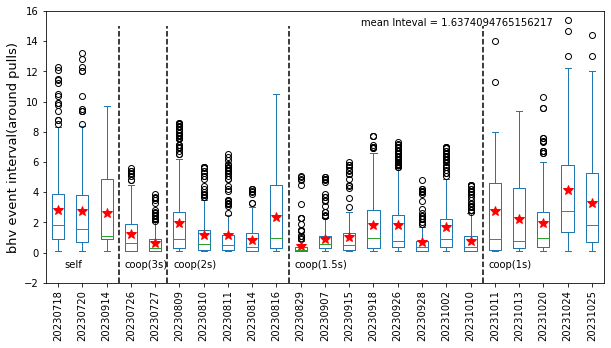

In [13]:
fig, ax1 = plt.subplots(figsize=(10, 5))
#
# sort the data based on task type and dates
sorting_df = pd.DataFrame({'dates': dates_list, 'coopthres': coopthres_forsort.ravel()}, columns=['dates', 'coopthres'])
sorting_df = sorting_df.sort_values(by=['coopthres','dates'], ascending = [False, True])
dates_list_sorted = np.array(dates_list)[sorting_df.index]
ndates_sorted = np.shape(dates_list_sorted)[0]

pull_other_intv_forplots = {}
pull_other_intv_mean = np.zeros((1,ndates_sorted))[0]
pull_other_intv_ii = []
for ii in np.arange(0,ndates_sorted,1):
    pull_other_intv_ii = pd.Series(bhv_intv_all_dates[dates_list_sorted[ii]]['pull_other_pooled'])
    # remove the interval that is too large
    pull_other_intv_ii[pull_other_intv_ii>(np.nanmean(pull_other_intv_ii)+2*np.nanstd(pull_other_intv_ii))]= np.nan    
    # pull_other_intv_ii[pull_other_intv_ii>10]= np.nan
    pull_other_intv_forplots[ii] = pull_other_intv_ii
    pull_other_intv_mean[ii] = np.nanmean(pull_other_intv_ii)
    
    
#
pull_other_intv_forplots = pd.DataFrame(pull_other_intv_forplots)

#
# plot
pull_other_intv_forplots.plot(kind = 'box',ax=ax1, positions=np.arange(0,ndates_sorted,1))
# plt.boxplot(pull_other_intv_forplots)
plt.plot(np.arange(0,ndates_sorted,1),pull_other_intv_mean,'r*',markersize=10)
#
ax1.set_ylabel("bhv event interval(around pulls)",fontsize=13)
ax1.set_ylim([-2,16])
#
plt.xticks(np.arange(0,ndates_sorted,1),dates_list_sorted, rotation=90,fontsize=10)
plt.yticks(fontsize=10)
#
tasktypes = ['self','coop(3s)','coop(2s)','coop(1.5s)','coop(1s)','no-vision']
taskswitches = np.where(np.array(sorting_df['coopthres'])[1:]-np.array(sorting_df['coopthres'])[:-1]!=0)[0]+0.5
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.plot([taskswitch,taskswitch],[-2,15],'k--')
taskswitches = np.concatenate(([0],taskswitches))
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.text(taskswitch+0.25,-1,tasktypes[itaskswitch],fontsize=10)
ax1.text(taskswitch-5,15,'mean Inteval = '+str(np.nanmean(pull_other_intv_forplots)),fontsize=10)
    
print(pull_other_intv_mean)
print(np.nanmean(pull_other_intv_forplots))

savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_BasicBhvAna_and_ContVariAna_Aniposelib3d_allsessions_basicEvents/'+savefile_sufix+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+"bhvInterval_hist_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'.jpg')
    

### plot some other basis behavioral measures
#### successful rate

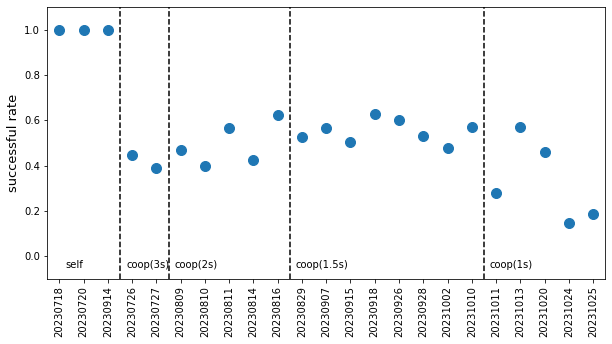

In [14]:
fig, ax1 = plt.subplots(figsize=(10, 5))
#
# sort the data based on task type and dates
sorting_df = pd.DataFrame({'dates': dates_list, 'coopthres': coopthres_forsort.ravel()}, columns=['dates', 'coopthres'])
sorting_df = sorting_df.sort_values(by=['coopthres','dates'], ascending = [False, True])
dates_list_sorted = np.array(dates_list)[sorting_df.index]
ndates_sorted = np.shape(dates_list_sorted)[0]


ax1.plot(np.arange(0,ndates_sorted,1),succ_rate_all_dates[sorting_df.index],'o',markersize=10)
#
ax1.set_ylabel("successful rate",fontsize=13)
ax1.set_ylim([-0.1,1.1])
ax1.set_xlim([-0.5,ndates_sorted-0.5])
#
plt.xticks(np.arange(0,ndates_sorted,1),dates_list_sorted, rotation=90,fontsize=10)
plt.yticks(fontsize=10)
#
tasktypes = ['self','coop(3s)','coop(2s)','coop(1.5s)','coop(1s)','no-vision']
taskswitches = np.where(np.array(sorting_df['coopthres'])[1:]-np.array(sorting_df['coopthres'])[:-1]!=0)[0]+0.5
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.plot([taskswitch,taskswitch],[-0.1,1.1],'k--')
taskswitches = np.concatenate(([0],taskswitches))
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.text(taskswitch+0.25,-0.05,tasktypes[itaskswitch],fontsize=10)
    
savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_BasicBhvAna_and_ContVariAna_Aniposelib3d_allsessions_basicEvents/'+savefile_sufix+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+"successfulrate_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'.jpg')


#### animal pull numbers

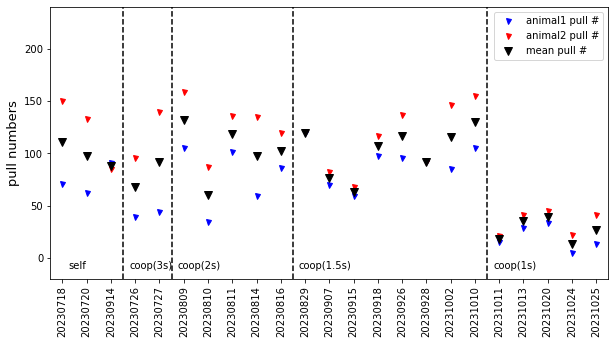

In [15]:
fig, ax1 = plt.subplots(figsize=(10, 5))
#
# sort the data based on task type and dates
sorting_df = pd.DataFrame({'dates': dates_list, 'coopthres': coopthres_forsort.ravel()}, columns=['dates', 'coopthres'])
sorting_df = sorting_df.sort_values(by=['coopthres','dates'], ascending = [False, True])
dates_list_sorted = np.array(dates_list)[sorting_df.index]
ndates_sorted = np.shape(dates_list_sorted)[0]

pullmean_num_all_dates = (pull1_num_all_dates+pull2_num_all_dates)/2
ax1.plot(np.arange(0,ndates_sorted,1),pull1_num_all_dates[sorting_df.index],'bv',markersize=5,label='animal1 pull #')
ax1.plot(np.arange(0,ndates_sorted,1),pull2_num_all_dates[sorting_df.index],'rv',markersize=5,label='animal2 pull #')
ax1.plot(np.arange(0,ndates_sorted,1),pullmean_num_all_dates[sorting_df.index],'kv',markersize=8,label='mean pull #')
ax1.legend()


#
ax1.set_ylabel("pull numbers",fontsize=13)
ax1.set_ylim([-20,240])
ax1.set_xlim([-0.5,ndates_sorted-0.5])

#
plt.xticks(np.arange(0,ndates_sorted,1),dates_list_sorted, rotation=90,fontsize=10)
plt.yticks(fontsize=10)
#
tasktypes = ['self','coop(3s)','coop(2s)','coop(1.5s)','coop(1s)','no-vision']
taskswitches = np.where(np.array(sorting_df['coopthres'])[1:]-np.array(sorting_df['coopthres'])[:-1]!=0)[0]+0.5
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.plot([taskswitch,taskswitch],[-20,240],'k--')
taskswitches = np.concatenate(([0],taskswitches))
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.text(taskswitch+0.25,-10,tasktypes[itaskswitch],fontsize=10)
    
savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_BasicBhvAna_and_ContVariAna_Aniposelib3d_allsessions_basicEvents/'+savefile_sufix+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+"pullnumbers_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'.jpg')


#### gaze number

In [16]:
gaze1_num_all_dates = owgaze1_num_all_dates + mtgaze1_num_all_dates
gaze2_num_all_dates = owgaze2_num_all_dates + mtgaze2_num_all_dates
gazemean_num_all_dates = (gaze1_num_all_dates+gaze2_num_all_dates)/2

print(np.nanmax(gaze1_num_all_dates))
print(np.nanmax(gaze2_num_all_dates))

0.1683070866141732
0.28911215911420957


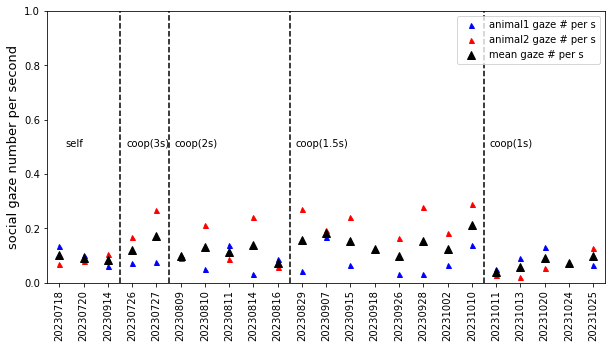

In [17]:
fig, ax1 = plt.subplots(figsize=(10, 5))
#
# sort the data based on task type and dates
sorting_df = pd.DataFrame({'dates': dates_list, 'coopthres': coopthres_forsort.ravel()}, columns=['dates', 'coopthres'])
sorting_df = sorting_df.sort_values(by=['coopthres','dates'], ascending = [False, True])
dates_list_sorted = np.array(dates_list)[sorting_df.index]
ndates_sorted = np.shape(dates_list_sorted)[0]



ax1.plot(np.arange(0,ndates_sorted,1),gaze1_num_all_dates[sorting_df.index],'b^',markersize=5,label='animal1 gaze # per s')
ax1.plot(np.arange(0,ndates_sorted,1),gaze2_num_all_dates[sorting_df.index],'r^',markersize=5,label='animal2 gaze # per s')
ax1.plot(np.arange(0,ndates_sorted,1),gazemean_num_all_dates[sorting_df.index],'k^',markersize=8,label='mean gaze # per s')
ax1.legend()


#
ax1.set_ylabel("social gaze number per second",fontsize=13)
# ax1.set_ylim([-20,1500])
ax1.set_ylim([0,1])
ax1.set_xlim([-0.5,ndates_sorted-0.5])

#
plt.xticks(np.arange(0,ndates_sorted,1),dates_list_sorted, rotation=90,fontsize=10)
plt.yticks(fontsize=10)
#
tasktypes = ['self','coop(3s)','coop(2s)','coop(1.5s)','coop(1s)','no-vision']
taskswitches = np.where(np.array(sorting_df['coopthres'])[1:]-np.array(sorting_df['coopthres'])[:-1]!=0)[0]+0.5
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    # ax1.plot([taskswitch,taskswitch],[-20,1500],'k--')
    ax1.plot([taskswitch,taskswitch],[0,1],'k--')
taskswitches = np.concatenate(([0],taskswitches))
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.text(taskswitch+0.25,0.5,tasktypes[itaskswitch],fontsize=10)
    
savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_BasicBhvAna_and_ContVariAna_Aniposelib3d_allsessions_basicEvents/'+savefile_sufix+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+"gazenumbers_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'.jpg')


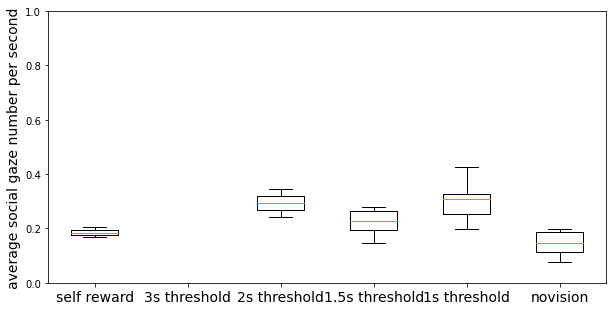

In [18]:
gaze_numbers = (owgaze1_num_all_dates+owgaze2_num_all_dates+mtgaze1_num_all_dates+mtgaze2_num_all_dates)
gaze_pull_ratios = (owgaze1_num_all_dates+owgaze2_num_all_dates+mtgaze1_num_all_dates+mtgaze2_num_all_dates)/(pull1_num_all_dates+pull2_num_all_dates)

fig, ax1 = plt.subplots(figsize=(10, 5))

grouptypes = ['self reward','3s threshold','2s threshold','1.5s threshold','1s threshold','novision']
# grouptypes = ['self reward','cooperative','no-vision']

gaze_numbers_groups = [np.transpose(gaze_numbers[np.transpose(coopthres_forsort==100)[0]])[0],
                       np.transpose(gaze_numbers[np.transpose(coopthres_forsort==3)[0]])[0],
                       np.transpose(gaze_numbers[np.transpose(coopthres_forsort==2)[0]])[0],
                      np.transpose(gaze_numbers[np.transpose(coopthres_forsort==1.5)[0]])[0],
                       np.transpose(gaze_numbers[np.transpose(coopthres_forsort==1)[0]])[0],
                       np.transpose(gaze_numbers[np.transpose(coopthres_forsort==-1)[0]])[0]]

gaze_numbers_plot = plt.boxplot(gaze_numbers_groups,whis=1.5, meanline=True)
# gaze_numbers_plot = seaborn.barplot(gaze_numbers_groups)
# seaborn.swarmplot(gaze_numbers_groups)

plt.xticks(np.arange(0+1, len(grouptypes)+1, 1), grouptypes, fontsize = 14);
# ax1.set_ylim([240/30,2100/30])
ax1.set_ylim([0,1])
ax1.set_ylabel("average social gaze number per second",fontsize=14)

savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_BasicBhvAna_and_ContVariAna_Aniposelib3d_allsessions_basicEvents/'+savefile_sufix+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+"averaged_gazenumbers_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pdf')


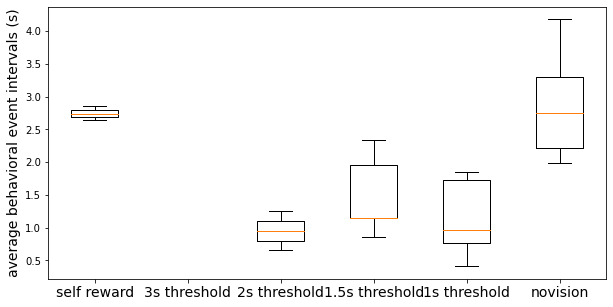

In [19]:
fig, ax1 = plt.subplots(figsize=(10, 5))

grouptypes = ['self reward','3s threshold','2s threshold','1.5s threshold','1s threshold','novision']
# grouptypes = ['self reward','cooperative','no-vision']

BhvIntv_groups = [pull_other_intv_mean[np.where(coopthres_forsort==100)[0]],
                  pull_other_intv_mean[np.where(coopthres_forsort==3)[0]],
                  pull_other_intv_mean[np.where(coopthres_forsort==2)[0]],
                  pull_other_intv_mean[np.where(coopthres_forsort==1.5)[0]],
                  pull_other_intv_mean[np.where(coopthres_forsort==1)[0]],
                  pull_other_intv_mean[np.where(coopthres_forsort==-1)[0]]
                 ]

#BhvIntv_groups = [np.array(pd.DataFrame.stack(pull_other_intv_forplots[np.where(np.isin(
#                  dates_list_sorted,dates_list_sorted[np.where(coopthres_forsort==100)[0]]))[0]])),
#                  np.array(pd.DataFrame.stack(pull_other_intv_forplots[np.where(np.isin(
#                  dates_list_sorted,dates_list_sorted[np.where(coopthres_forsort==1)[0]]))[0]])),
#                  np.array(pd.DataFrame.stack(pull_other_intv_forplots[np.where(np.isin(
#                  dates_list_sorted,dates_list_sorted[np.where(coopthres_forsort==-1)[0]]))[0]])),
#                 ]

gaze_numbers_plot = plt.boxplot(BhvIntv_groups,whis=3, meanline=True)
# gaze_numbers_plot = seaborn.barplot(BhvIntv_groups)
# seaborn.swarmplot(BhvIntv_groups)

plt.xticks(np.arange(0+1, len(grouptypes)+1, 1), grouptypes, fontsize = 14);
#ax1.set_ylim([250,2000])
ax1.set_ylabel("average behavioral event intervals (s)",fontsize=14)

savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_BasicBhvAna_and_ContVariAna_Aniposelib3d_allsessions_basicEvents/'+savefile_sufix+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+"averaged_bhvIntv_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pdf')

#### plot the gaze numbers for all individuals 

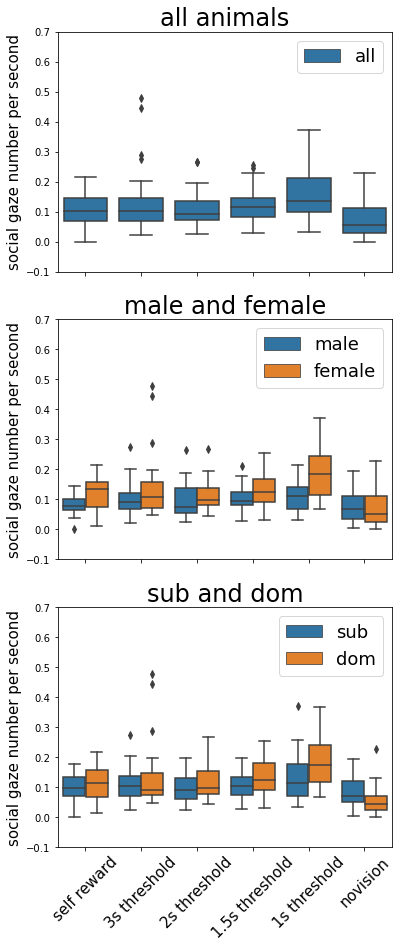

In [20]:
animal1_fixedorders = ['eddie','dodson','dannon','ginger','koala']
animal2_fixedorders = ['sparkle','scorch','kanga_1','kanga_2','vermelho']
nanimalpairs = np.shape(animal1_fixedorders)[0]

grouptypes = ['self reward','3s threshold','2s threshold','1.5s threshold','1s threshold','novision']
coopthres_IDs = [100, 3, 2, 1.5, 1, -1]
ngrouptypes = np.shape(grouptypes)[0]

gazenum_foreachgroup_foreachAni = dict.fromkeys(grouptypes,[])
gazenum_foreachgroup_all = dict.fromkeys(grouptypes,[])
#
malenames = ['eddie','dodson','dannon','vermelho']
femalenames = ['sparkle','scorch','kanga_1','kanga_2','ginger','koala']
gazenum_foreachgroup_male = dict.fromkeys(grouptypes,[])
gazenum_foreachgroup_female = dict.fromkeys(grouptypes,[])
#
subnames = ['eddie','dodson','dannon','ginger','koala']
domnames = ['sparkle','scorch','kanga_1','kanga_2','vermelho']
gazenum_foreachgroup_sub = dict.fromkeys(grouptypes,[])
gazenum_foreachgroup_dom = dict.fromkeys(grouptypes,[])

#
for igrouptype in np.arange(0,ngrouptypes,1):
    
    grouptype = grouptypes[igrouptype]
    coopthres_ID = coopthres_IDs[igrouptype]
    
    gazenum_foreachgroup_foreachAni[grouptype] = dict.fromkeys(animal1_fixedorders+animal2_fixedorders,[])

    #
    for ianimalpair in np.arange(0,nanimalpairs,1):
        animal1 = animal1_fixedorders[ianimalpair]
        animal2 = animal2_fixedorders[ianimalpair]
        
        if (animal2 == 'kanga_1') | (animal2 == 'kanga_2'):
            animal2_filename = 'kanga'
        else:
            animal2_filename = animal2

        data_saved_subfolder = data_saved_folder+'data_saved_combinedsessions_Anipose'+savefile_sufix+'/'+animal1+animal2_filename+'/'
        with open(data_saved_subfolder+'/owgaze1_num_all_dates_'+animal1+animal2_filename+'.pkl', 'rb') as f:
            owgaze1_num_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/owgaze2_num_all_dates_'+animal1+animal2_filename+'.pkl', 'rb') as f:
            owgaze2_num_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/mtgaze1_num_all_dates_'+animal1+animal2_filename+'.pkl', 'rb') as f:
            mtgaze1_num_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/mtgaze2_num_all_dates_'+animal1+animal2_filename+'.pkl', 'rb') as f:
            mtgaze2_num_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/pull1_num_all_dates_'+animal1+animal2_filename+'.pkl', 'rb') as f:
            pull1_num_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/pull2_num_all_dates_'+animal1+animal2_filename+'.pkl', 'rb') as f:
            pull2_num_all_dates = pickle.load(f)

        with open(data_saved_subfolder+'/tasktypes_all_dates_'+animal1+animal2_filename+'.pkl', 'rb') as f:
            tasktypes_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/coopthres_all_dates_'+animal1+animal2_filename+'.pkl', 'rb') as f:
            coopthres_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/succ_rate_all_dates_'+animal1+animal2_filename+'.pkl', 'rb') as f:
            succ_rate_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/interpullintv_all_dates_'+animal1+animal2_filename+'.pkl', 'rb') as f:
            interpullintv_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/trialnum_all_dates_'+animal1+animal2_filename+'.pkl', 'rb') as f:
            trialnum_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/bhv_intv_all_dates_'+animal1+animal2_filename+'.pkl', 'rb') as f:
            bhv_intv_all_dates = pickle.load(f)

        # combine owgaze and mtgaze
        gaze1_num_all_dates = owgaze1_num_all_dates + mtgaze1_num_all_dates
        gaze2_num_all_dates = owgaze2_num_all_dates + mtgaze2_num_all_dates

        #
        # 100: self; 3: 3s coop; 2: 2s coop; 1.5: 1.5s coop; 1: 1s coop; -1: no-vision
        tasktypes_all_dates[tasktypes_all_dates==5] = -1 # change the task type code for no-vision
        coopthres_forsort = (tasktypes_all_dates-1)*coopthres_all_dates/2
        coopthres_forsort[coopthres_forsort==0] = 100 # get the cooperation threshold for sorting

        # 
        gazenum_foreachgroup_foreachAni[grouptype][animal1] = gaze1_num_all_dates[coopthres_forsort==coopthres_ID]
        gazenum_foreachgroup_foreachAni[grouptype][animal2] = gaze2_num_all_dates[coopthres_forsort==coopthres_ID]
        
    
    # combine across all animals
    gazenum_foreachgroup_all[grouptype] = np.hstack(list(gazenum_foreachgroup_foreachAni[grouptype].values()))
    
    # combine across male and female
    df = pd.DataFrame.from_dict(gazenum_foreachgroup_foreachAni[grouptype],orient='index')
    df = df.transpose()[malenames]
    gazenum_foreachgroup_male[grouptype] = df.values.ravel()
    #
    df = pd.DataFrame.from_dict(gazenum_foreachgroup_foreachAni[grouptype],orient='index')
    df = df.transpose()[femalenames]
    gazenum_foreachgroup_female[grouptype] = df.values.ravel()
    
    # combine across sub and dom
    df = pd.DataFrame.from_dict(gazenum_foreachgroup_foreachAni[grouptype],orient='index')
    df = df.transpose()[subnames]
    gazenum_foreachgroup_sub[grouptype] = df.values.ravel()
    #
    df = pd.DataFrame.from_dict(gazenum_foreachgroup_foreachAni[grouptype],orient='index')
    df = df.transpose()[domnames]
    gazenum_foreachgroup_dom[grouptype] = df.values.ravel()
    
    
        
# box plot 
fig, axs = plt.subplots(3,1)
fig.set_figheight(5*3)
fig.set_figwidth(3*2)

# subplot 1 - all animals
gazenum_foreachgroup_all_df = pd.DataFrame.from_dict(gazenum_foreachgroup_all,orient='index')
gazenum_foreachgroup_all_df = gazenum_foreachgroup_all_df.transpose()
gazenum_foreachgroup_all_df['type'] = 'all'
#
df_long=pd.concat([gazenum_foreachgroup_all_df])
df_long2 = df_long.melt(id_vars=['type'], value_vars=grouptypes,var_name='condition', value_name='value')
# 
# barplot ans swarmplot
seaborn.boxplot(ax=axs[0],data=df_long2,x='condition',y='value',hue='type')
# seaborn.swarmplot(ax=axs[0],data=df_long2,x='condition',y='value',hue='type',alpha=.9,size= 9,dodge=True,legend=False)
axs[0].set_xlabel('')
axs[0].set_xticklabels('')
axs[0].xaxis.set_tick_params(labelsize=15)
axs[0].set_ylabel("social gaze number per second",fontsize=15)
axs[0].set_title('all animals' ,fontsize=24)
axs[0].set_ylim([-0.1,0.7])
axs[0].legend(fontsize=18)

# subplot 2 - male and female animals
gazenum_foreachgroup_male_df = pd.DataFrame.from_dict(gazenum_foreachgroup_male,orient='index')
gazenum_foreachgroup_male_df = gazenum_foreachgroup_male_df.transpose()
gazenum_foreachgroup_male_df['type'] = 'male'
gazenum_foreachgroup_female_df = pd.DataFrame.from_dict(gazenum_foreachgroup_female,orient='index')
gazenum_foreachgroup_female_df = gazenum_foreachgroup_female_df.transpose()
gazenum_foreachgroup_female_df['type'] = 'female'
#
df_long=pd.concat([gazenum_foreachgroup_male_df,gazenum_foreachgroup_female_df])
df_long2 = df_long.melt(id_vars=['type'], value_vars=grouptypes,var_name='condition', value_name='value')
# 
# barplot ans swarmplot
seaborn.boxplot(ax=axs[1],data=df_long2,x='condition',y='value',hue='type')
# seaborn.swarmplot(ax=axs[1],data=df_long2,x='condition',y='value',hue='type',alpha=.9,size= 9,dodge=True,legend=False)
axs[1].set_xlabel('')
axs[1].set_xticklabels('')
axs[1].xaxis.set_tick_params(labelsize=15)
axs[1].set_ylabel("social gaze number per second",fontsize=15)
axs[1].set_title('male and female' ,fontsize=24)
axs[1].set_ylim([-0.1,0.7])
axs[1].legend(fontsize=18)

# subplot 3 - dom and sub animals
gazenum_foreachgroup_sub_df = pd.DataFrame.from_dict(gazenum_foreachgroup_sub,orient='index')
gazenum_foreachgroup_sub_df = gazenum_foreachgroup_sub_df.transpose()
gazenum_foreachgroup_sub_df['type'] = 'sub'
gazenum_foreachgroup_dom_df = pd.DataFrame.from_dict(gazenum_foreachgroup_dom,orient='index')
gazenum_foreachgroup_dom_df = gazenum_foreachgroup_dom_df.transpose()
gazenum_foreachgroup_dom_df['type'] = 'dom'
#
df_long=pd.concat([gazenum_foreachgroup_sub_df,gazenum_foreachgroup_dom_df])
df_long2 = df_long.melt(id_vars=['type'], value_vars=grouptypes,var_name='condition', value_name='value')
# 
# barplot ans swarmplot
seaborn.boxplot(ax=axs[2],data=df_long2,x='condition',y='value',hue='type')
# seaborn.swarmplot(ax=axs[2],data=df_long2,x='condition',y='value',hue='type',alpha=.9,size= 9,dodge=True,legend=False)
axs[2].set_xlabel('')
axs[2].set_xticklabels(axs[2].get_xticklabels(),rotation=45)
axs[2].xaxis.set_tick_params(labelsize=15)
axs[2].set_ylabel("social gaze number per second",fontsize=15)
axs[2].set_title('sub and dom' ,fontsize=24)
axs[2].set_ylim([-0.1,0.7])
axs[2].legend(fontsize=18)

        
savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_BasicBhvAna_and_ContVariAna_Aniposelib3d_allsessions_basicEvents/'+savefile_sufix+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+'averaged_gazenumbers_acrossAllAnimals.pdf')    


In [21]:
# perform the anova on all animals
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

gazenum_foreachgroup_all_df = pd.DataFrame.from_dict(gazenum_foreachgroup_all,orient='index')
gazenum_foreachgroup_all_df = gazenum_foreachgroup_all_df.transpose()
gazenum_foreachgroup_all_df['type'] = 'all'
#
df_long=pd.concat([gazenum_foreachgroup_all_df])
df_long2 = df_long.melt(id_vars=['type'], value_vars=grouptypes,var_name='condition', value_name='value')
df_long2 = df_long2[~np.isnan(df_long2['value'])]

# anova
cw_lm=ols('value ~ condition', data=df_long2).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=2))

# post hoc test 
tukey = pairwise_tukeyhsd(endog=df_long2['value'], groups=df_long2['condition'], alpha=0.05)
print(tukey)


             sum_sq     df         F        PR(>F)
condition  0.211662    5.0  8.847923  9.198395e-08
Residual   1.224816  256.0       NaN           NaN
       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1        group2    meandiff p-adj   lower   upper  reject
------------------------------------------------------------------
1.5s threshold 1s threshold   0.0361 0.0705 -0.0017  0.0738  False
1.5s threshold 2s threshold  -0.0121    0.9 -0.0542  0.0301  False
1.5s threshold 3s threshold   0.0115    0.9 -0.0327  0.0556  False
1.5s threshold     novision  -0.0508  0.006 -0.0918 -0.0097   True
1.5s threshold  self reward  -0.0164    0.9 -0.0614  0.0285  False
  1s threshold 2s threshold  -0.0482  0.009 -0.0884 -0.0079   True
  1s threshold 3s threshold  -0.0246 0.5475  -0.067  0.0178  False
  1s threshold     novision  -0.0869  0.001  -0.126 -0.0477   True
  1s threshold  self reward  -0.0525 0.0075 -0.0958 -0.0093   True
  2s threshold 3s threshold   0.0236 0.6661

In [22]:
# perform the anova on male and female
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

gazenum_foreachgroup_male_df = pd.DataFrame.from_dict(gazenum_foreachgroup_male,orient='index')
gazenum_foreachgroup_male_df = gazenum_foreachgroup_male_df.transpose()
gazenum_foreachgroup_male_df['type'] = 'male'
gazenum_foreachgroup_female_df = pd.DataFrame.from_dict(gazenum_foreachgroup_female,orient='index')
gazenum_foreachgroup_female_df = gazenum_foreachgroup_female_df.transpose()
gazenum_foreachgroup_female_df['type'] = 'female'
#
df_long=pd.concat([gazenum_foreachgroup_male_df,gazenum_foreachgroup_female_df])
df_long2 = df_long.melt(id_vars=['type'], value_vars=grouptypes,var_name='condition', value_name='value')
df_long2 = df_long2[~np.isnan(df_long2['value'])]

# anova
cw_lm=ols('value ~ type + condition + type:condition', data=df_long2).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=2))

# post hoc test 
tukey = pairwise_tukeyhsd(endog=df_long2['value'], groups=df_long2['condition']+df_long2['type'], alpha=0.05)
print(tukey)


                  sum_sq     df          F        PR(>F)
type            0.074150    1.0  16.904542  5.335441e-05
condition       0.216044    5.0   9.850668  1.307358e-08
type:condition  0.054073    5.0   2.465490  3.337838e-02
Residual        1.096594  250.0        NaN           NaN
             Multiple Comparison of Means - Tukey HSD, FWER=0.05              
       group1              group2       meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------
1.5s thresholdfemale 1.5s thresholdmale  -0.0319 0.8736  -0.095  0.0312  False
1.5s thresholdfemale 1s thresholdfemale   0.0557 0.0365  0.0017  0.1098   True
1.5s thresholdfemale   1s thresholdmale  -0.0216    0.9 -0.0801   0.037  False
1.5s thresholdfemale 2s thresholdfemale  -0.0196    0.9 -0.0794  0.0403  False
1.5s thresholdfemale   2s thresholdmale  -0.0327    0.9 -0.1004  0.0349  False
1.5s thresholdfemale 3s thresholdfemale   0.0141    0.9 -0.0481  0.0763  False
1.5s

#### plot the correlation between gaze number and sucessful rates

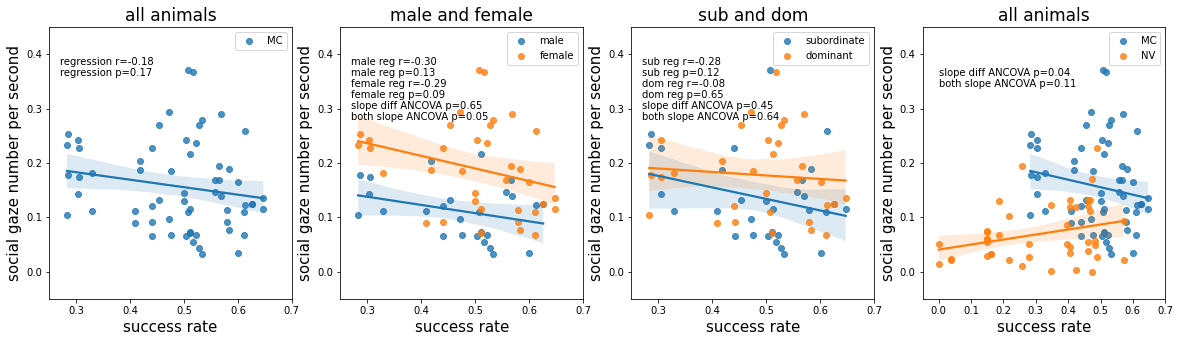

In [29]:
animal1_fixedorders = ['eddie','dodson','dannon','ginger','koala']
animal2_fixedorders = ['sparkle','scorch','kanga_1','kanga_2','vermelho']
nanimalpairs = np.shape(animal1_fixedorders)[0]

grouptypes = ['self reward','3s threshold','2s threshold','1.5s threshold','1s threshold','novision']
coopthres_IDs = [100, 3, 2, 1.5, 1, -1]
ngrouptypes = np.shape(grouptypes)[0]

gazenum_foreachgroup_foreachAni = dict.fromkeys(grouptypes,[])
gazenum_foreachgroup_all = dict.fromkeys(grouptypes,[])
succrate_foreachgroup_foreachAni = dict.fromkeys(grouptypes,[])
succrate_foreachgroup_all = dict.fromkeys(grouptypes,[])
#
malenames = ['eddie','dodson','dannon','vermelho']
femalenames = ['sparkle','scorch','kanga_1','kanga_2','ginger','koala']
gazenum_foreachgroup_male = dict.fromkeys(grouptypes,[])
gazenum_foreachgroup_female = dict.fromkeys(grouptypes,[])
succrate_foreachgroup_male = dict.fromkeys(grouptypes,[])
succrate_foreachgroup_female = dict.fromkeys(grouptypes,[])
#
subnames = ['eddie','dodson','dannon','ginger','koala']
domnames = ['sparkle','scorch','kanga_1','kanga_2','vermelho']
gazenum_foreachgroup_sub = dict.fromkeys(grouptypes,[])
gazenum_foreachgroup_dom = dict.fromkeys(grouptypes,[])
succrate_foreachgroup_sub = dict.fromkeys(grouptypes,[])
succrate_foreachgroup_dom = dict.fromkeys(grouptypes,[])

#
for igrouptype in np.arange(0,ngrouptypes,1):
    
    grouptype = grouptypes[igrouptype]
    coopthres_ID = coopthres_IDs[igrouptype]
    
    gazenum_foreachgroup_foreachAni[grouptype] = dict.fromkeys(animal1_fixedorders+animal2_fixedorders,[])
    succrate_foreachgroup_foreachAni[grouptype] = dict.fromkeys(animal1_fixedorders+animal2_fixedorders,[])

    #
    for ianimalpair in np.arange(0,nanimalpairs,1):
        animal1 = animal1_fixedorders[ianimalpair]
        animal2 = animal2_fixedorders[ianimalpair]
        
        if (animal2 == 'kanga_1') | (animal2 == 'kanga_2'):
            animal2_filename = 'kanga'
        else:
            animal2_filename = animal2

        data_saved_subfolder = data_saved_folder+'data_saved_combinedsessions_Anipose'+savefile_sufix+'/'+animal1+animal2_filename+'/'
        with open(data_saved_subfolder+'/owgaze1_num_all_dates_'+animal1+animal2_filename+'.pkl', 'rb') as f:
            owgaze1_num_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/owgaze2_num_all_dates_'+animal1+animal2_filename+'.pkl', 'rb') as f:
            owgaze2_num_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/mtgaze1_num_all_dates_'+animal1+animal2_filename+'.pkl', 'rb') as f:
            mtgaze1_num_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/mtgaze2_num_all_dates_'+animal1+animal2_filename+'.pkl', 'rb') as f:
            mtgaze2_num_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/pull1_num_all_dates_'+animal1+animal2_filename+'.pkl', 'rb') as f:
            pull1_num_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/pull2_num_all_dates_'+animal1+animal2_filename+'.pkl', 'rb') as f:
            pull2_num_all_dates = pickle.load(f)

        with open(data_saved_subfolder+'/tasktypes_all_dates_'+animal1+animal2_filename+'.pkl', 'rb') as f:
            tasktypes_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/coopthres_all_dates_'+animal1+animal2_filename+'.pkl', 'rb') as f:
            coopthres_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/succ_rate_all_dates_'+animal1+animal2_filename+'.pkl', 'rb') as f:
            succ_rate_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/interpullintv_all_dates_'+animal1+animal2_filename+'.pkl', 'rb') as f:
            interpullintv_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/trialnum_all_dates_'+animal1+animal2_filename+'.pkl', 'rb') as f:
            trialnum_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/bhv_intv_all_dates_'+animal1+animal2_filename+'.pkl', 'rb') as f:
            bhv_intv_all_dates = pickle.load(f)

        # combine owgaze and mtgaze
        gaze1_num_all_dates = owgaze1_num_all_dates + mtgaze1_num_all_dates
        gaze2_num_all_dates = owgaze2_num_all_dates + mtgaze2_num_all_dates

        #
        # 100: self; 3: 3s coop; 2: 2s coop; 1.5: 1.5s coop; 1: 1s coop; -1: no-vision
        tasktypes_all_dates[tasktypes_all_dates==5] = -1 # change the task type code for no-vision
        coopthres_forsort = (tasktypes_all_dates-1)*coopthres_all_dates/2
        coopthres_forsort[coopthres_forsort==0] = 100 # get the cooperation threshold for sorting

        # 
        gazenum_foreachgroup_foreachAni[grouptype][animal1] = gaze1_num_all_dates[coopthres_forsort==coopthres_ID]
        gazenum_foreachgroup_foreachAni[grouptype][animal2] = gaze2_num_all_dates[coopthres_forsort==coopthres_ID]
        succrate_foreachgroup_foreachAni[grouptype][animal1] = succ_rate_all_dates[coopthres_forsort==coopthres_ID]
        succrate_foreachgroup_foreachAni[grouptype][animal2] = succ_rate_all_dates[coopthres_forsort==coopthres_ID]
    
    # combine across all animals
    gazenum_foreachgroup_all[grouptype] = np.hstack(list(gazenum_foreachgroup_foreachAni[grouptype].values()))
    succrate_foreachgroup_all[grouptype] = np.hstack(list(succrate_foreachgroup_foreachAni[grouptype].values()))
    
    # combine across male and female
    # gaze number
    df = pd.DataFrame.from_dict(gazenum_foreachgroup_foreachAni[grouptype],orient='index')
    df = df.transpose()[malenames]
    gazenum_foreachgroup_male[grouptype] = df.values.ravel()
    #
    df = pd.DataFrame.from_dict(gazenum_foreachgroup_foreachAni[grouptype],orient='index')
    df = df.transpose()[femalenames]
    gazenum_foreachgroup_female[grouptype] = df.values.ravel()
    # successful rate
    df = pd.DataFrame.from_dict(succrate_foreachgroup_foreachAni[grouptype],orient='index')
    df = df.transpose()[malenames]
    succrate_foreachgroup_male[grouptype] = df.values.ravel()
    #
    df = pd.DataFrame.from_dict(succrate_foreachgroup_foreachAni[grouptype],orient='index')
    df = df.transpose()[femalenames]
    succrate_foreachgroup_female[grouptype] = df.values.ravel()
    
    # combine across sub and dom
    # gaze number
    df = pd.DataFrame.from_dict(gazenum_foreachgroup_foreachAni[grouptype],orient='index')
    df = df.transpose()[subnames]
    gazenum_foreachgroup_sub[grouptype] = df.values.ravel()
    #
    df = pd.DataFrame.from_dict(gazenum_foreachgroup_foreachAni[grouptype],orient='index')
    df = df.transpose()[domnames]
    gazenum_foreachgroup_dom[grouptype] = df.values.ravel()
    # successful rate
    df = pd.DataFrame.from_dict(succrate_foreachgroup_foreachAni[grouptype],orient='index')
    df = df.transpose()[subnames]
    succrate_foreachgroup_sub[grouptype] = df.values.ravel()
    #
    df = pd.DataFrame.from_dict(succrate_foreachgroup_foreachAni[grouptype],orient='index')
    df = df.transpose()[domnames]
    succrate_foreachgroup_dom[grouptype] = df.values.ravel()
    
        
# scatter plot + correlation line 
fig, axs = plt.subplots(1,4)
fig.set_figheight(5*1)
fig.set_figwidth(5*4)

# condtypes_forplot = ['3s threshold','2s threshold','1.5s threshold','1s threshold']
condtypes_forplot = ['1s threshold']
# condtypes_forplot = ['novision']

# subplot 1 - all animals
xxx = np.hstack([succrate_foreachgroup_all[condname] for condname in condtypes_forplot])
yyy = np.hstack([gazenum_foreachgroup_all[condname] for condname in condtypes_forplot])
p_reg = scipy.stats.linregress(xxx, yyy, alternative='two-sided').pvalue
r_reg = scipy.stats.linregress(xxx, yyy, alternative='two-sided').rvalue
# 
seaborn.regplot(ax=axs[0], x=xxx, y=yyy,label='MC')
axs[0].set_title('all animals' ,fontsize=17)
axs[0].set_xlabel('success rate',fontsize=15)
axs[0].set_xlim([0.25,0.7])
axs[0].set_ylabel("social gaze number per second",fontsize=15)
axs[0].set_ylim([-0.05,0.45])
axs[0].legend()
axs[0].text(0.27,0.38,'regression r='+"{:.2f}".format(r_reg),fontsize=10)
axs[0].text(0.27,0.36,'regression p='+"{:.2f}".format(p_reg),fontsize=10)

# subplot 2 - male and female
xxx_m = np.hstack([succrate_foreachgroup_male[condname] for condname in condtypes_forplot])
yyy_m = np.hstack([gazenum_foreachgroup_male[condname] for condname in condtypes_forplot])
ind_good = ~np.isnan(xxx_m) & ~np.isnan(yyy_m)
xxx_m = xxx_m[ind_good]
yyy_m = yyy_m[ind_good]
dfm = pd.DataFrame({'succrate':xxx_m,'gazenum':yyy_m})
dfm['condtype'] = 'male'
p_reg_m = scipy.stats.linregress(xxx_m, yyy_m, alternative='two-sided').pvalue
r_reg_m = scipy.stats.linregress(xxx_m, yyy_m, alternative='two-sided').rvalue
#
xxx_f = np.hstack([succrate_foreachgroup_female[condname] for condname in condtypes_forplot])
yyy_f = np.hstack([gazenum_foreachgroup_female[condname] for condname in condtypes_forplot])
ind_good = ~np.isnan(xxx_f) & ~np.isnan(yyy_f)
xxx_f = xxx_f[ind_good]
yyy_f = yyy_f[ind_good]
dff = pd.DataFrame({'succrate':xxx_f,'gazenum':yyy_f})
dff['condtype'] = 'female'
p_reg_f = scipy.stats.linregress(xxx_f, yyy_f, alternative='two-sided').pvalue
r_reg_f = scipy.stats.linregress(xxx_f, yyy_f, alternative='two-sided').rvalue
# 
dfmf = pd.concat([dfm,dff]).reset_index(drop=True)
model_interaction = sm.formula.ols('gazenum ~ succrate + condtype + succrate*condtype', data=dfmf).fit()
p_slopediff = model_interaction.pvalues['succrate:condtype[T.male]']
p_slopeboth = model_interaction.pvalues['succrate']
#
seaborn.regplot(ax=axs[1], x=xxx_m, y=yyy_m,label='male')
seaborn.regplot(ax=axs[1], x=xxx_f, y=yyy_f,label='female')
axs[1].set_title('male and female' ,fontsize=17)
axs[1].set_xlabel('success rate',fontsize=15)
axs[1].set_xlim([0.25,0.7])
axs[1].set_ylabel("social gaze number per second",fontsize=15)
axs[1].set_ylim([-0.05,0.45])
axs[1].legend()
axs[1].text(0.27,0.38,'male reg r='+"{:.2f}".format(r_reg_m),fontsize=10)
axs[1].text(0.27,0.36,'male reg p='+"{:.2f}".format(p_reg_m),fontsize=10)
axs[1].text(0.27,0.34,'female reg r='+"{:.2f}".format(r_reg_f),fontsize=10)
axs[1].text(0.27,0.32,'female reg p='+"{:.2f}".format(p_reg_f),fontsize=10)
axs[1].text(0.27,0.30,'slope diff ANCOVA p='+"{:.2f}".format(p_slopediff),fontsize=10)
axs[1].text(0.27,0.28,'both slope ANCOVA p='+"{:.2f}".format(p_slopeboth),fontsize=10)

# subplot 3 - sub and dom
xxx_s = np.hstack([succrate_foreachgroup_sub[condname] for condname in condtypes_forplot])
yyy_s = np.hstack([gazenum_foreachgroup_sub[condname] for condname in condtypes_forplot])
ind_good = ~np.isnan(xxx_s) & ~np.isnan(yyy_s)
xxx_s = xxx_s[ind_good]
yyy_s = yyy_s[ind_good]
dfs = pd.DataFrame({'succrate':xxx_s,'gazenum':yyy_s})
dfs['condtype'] = 'sub'
p_reg_s = scipy.stats.linregress(xxx_s, yyy_s, alternative='two-sided').pvalue
r_reg_s = scipy.stats.linregress(xxx_s, yyy_s, alternative='two-sided').rvalue
#
xxx_d = np.hstack([succrate_foreachgroup_dom[condname] for condname in condtypes_forplot])
yyy_d = np.hstack([gazenum_foreachgroup_dom[condname] for condname in condtypes_forplot])
ind_good = ~np.isnan(xxx_d) & ~np.isnan(yyy_d)
xxx_d = xxx_d[ind_good]
yyy_d = yyy_d[ind_good]
dfd = pd.DataFrame({'succrate':xxx_d,'gazenum':yyy_d})
dfd['condtype'] = 'dom'
p_reg_d = scipy.stats.linregress(xxx_d, yyy_d, alternative='two-sided').pvalue
r_reg_d = scipy.stats.linregress(xxx_d, yyy_d, alternative='two-sided').rvalue
# 
dfsd = pd.concat([dfs,dfd]).reset_index(drop=True)
model_interaction = sm.formula.ols('gazenum ~ succrate + condtype + succrate*condtype', data=dfsd).fit()
p_slopediff = model_interaction.pvalues['succrate:condtype[T.sub]']
p_slopeboth = model_interaction.pvalues['succrate']
# 
seaborn.regplot(ax=axs[2], x=xxx_s, y=yyy_s,label='subordinate')
seaborn.regplot(ax=axs[2], x=xxx_d, y=yyy_d,label='dominant')
axs[2].set_title('sub and dom' ,fontsize=17)
axs[2].set_xlabel('success rate',fontsize=15)
axs[2].set_xlim([0.25,0.7])
axs[2].set_ylabel("social gaze number per second",fontsize=15)
axs[2].set_ylim([-0.05,0.45])
axs[2].legend()
axs[2].text(0.27,0.38,'sub reg r='+"{:.2f}".format(r_reg_s),fontsize=10)
axs[2].text(0.27,0.36,'sub reg p='+"{:.2f}".format(p_reg_s),fontsize=10)
axs[2].text(0.27,0.34,'dom reg r='+"{:.2f}".format(r_reg_d),fontsize=10)
axs[2].text(0.27,0.32,'dom reg p='+"{:.2f}".format(p_reg_d),fontsize=10)
axs[2].text(0.27,0.30,'slope diff ANCOVA p='+"{:.2f}".format(p_slopediff),fontsize=10)
axs[2].text(0.27,0.28,'both slope ANCOVA p='+"{:.2f}".format(p_slopeboth),fontsize=10)

    
# ancova comparison of regression slopes (between cooperation and NV)
#
# condtypes_forplot = ['3s threshold','2s threshold','1.5s threshold','1s threshold']
condtype1_forplot = ['1s threshold']
condtype2_forplot = ['novision']
#
xxx1 = np.hstack([succrate_foreachgroup_all[condname] for condname in condtype1_forplot])
yyy1 = np.hstack([gazenum_foreachgroup_all[condname] for condname in condtype1_forplot])
df1 = pd.DataFrame({'succrate':xxx1,'gazenum':yyy1})
df1['condtype'] = 'coop'
#
xxx2 = np.hstack([succrate_foreachgroup_all[condname] for condname in condtype2_forplot])
yyy2 = np.hstack([gazenum_foreachgroup_all[condname] for condname in condtype2_forplot])
df2 = pd.DataFrame({'succrate':xxx2,'gazenum':yyy2})
df2['condtype'] = 'nov'
#
df12 = pd.concat([df1,df2]).reset_index(drop=True)
#
model_interaction = sm.formula.ols('gazenum ~ succrate + condtype + succrate*condtype', data=df12).fit()
p_slopediff = model_interaction.pvalues['succrate:condtype[T.nov]']
p_slopeboth = model_interaction.pvalues['succrate']
#
seaborn.regplot(ax=axs[3], data = df12[df12['condtype']=='coop'], x='succrate', y='gazenum',label='MC')
seaborn.regplot(ax=axs[3], data = df12[df12['condtype']=='nov'], x='succrate', y='gazenum',label = 'NV')
#
axs[3].set_title('all animals' ,fontsize=17)
axs[3].set_xlabel('success rate',fontsize=15)
axs[3].set_xlim([-0.05,0.7])
axs[3].set_ylabel("social gaze number per second",fontsize=15)
axs[3].set_ylim([-0.05,0.45])
axs[3].legend()
axs[3].text(0.00,0.36,'slope diff ANCOVA p='+"{:.2f}".format(p_slopediff),fontsize=10)
axs[3].text(0.00,0.34,'both slope ANCOVA p='+"{:.2f}".format(p_slopeboth),fontsize=10)


savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_BasicBhvAna_and_ContVariAna_Aniposelib3d_allsessions_basicEvents/'+savefile_sufix+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+'gazenumbers_succrate_correlation_acrossAllAnimals.pdf')   

In [36]:
model_interaction.pvalues

Intercept                   0.000001
condtype[T.nov]             0.000306
succrate                    0.114078
succrate:condtype[T.nov]    0.036190
dtype: float64

### plot pull triggered event related plot
#### plot averaged trace for all pulls, seprating into different training groups

In [ ]:
varis_toplot = ['gaze_other_angle','othergaze_self_angle','mass_move_speed','gaze_angle_speed']
varis_ylabel = ['degree','degree','pixel/s','degree/s']
varis_tracecolor = ['r','#458B74','#FFC710','#FF1493'] 
varis_ylims = [[0,np.pi],[0,np.pi],[0,20],[0,1]]
nvaris = np.shape(varis_toplot)[0]
animal1_toplot = animal1_fixedorder[0]
animal2_toplot = animal2_fixedorder[0]

# different session conditions
#group_typenames = ['self','coop(3s)','coop(2s)','coop(1.5s)','coop(1s)','no-vision']
#group_typeIDs  =  [1,3,3,  3,3,5]
#group_coopthres = [0,3,2,1.5,1,0]
#group_sorting_df_coopthres = [100,3,2,1.5,1,-1]
group_typenames = ['self','coop(1s)','no-vision']
group_typeIDs  =  [1,3,5]
group_coopthres = [0,1,0]
group_sorting_df_coopthres = [100,1,-1]
ngroups = np.shape(group_typenames)[0]
#
sorting_df = pd.DataFrame({'dates': dates_list, 'coopthres': coopthres_forsort.ravel()}, columns=['dates', 'coopthres'])
sorting_df = sorting_df.sort_values(by=['coopthres','dates'], ascending = [False, True])
dates_list_sorted = np.array(dates_list)[sorting_df.index]

fig, axs = plt.subplots(nvaris*2,ngroups)
fig.set_figheight(10*nvaris*2)
fig.set_figwidth(10*ngroups)

# set the x axis info, make sure they are the same as in plot_continuous_bhv_var.py
trig_twin = [-6,6] #s
xxx_trigevent = np.arange(trig_twin[0],trig_twin[1],1/fps) 

for igroup in np.arange(0,ngroups,1):
    
    igroup_typename = group_typenames[igroup] 
    igroup_typeID =  group_typeIDs[igroup] 
    igroup_cothres = group_coopthres[igroup]
    igroup_sorting_df_coopthres = group_sorting_df_coopthres[igroup]

    igroup_dates_tgt = sorting_df['dates'][sorting_df['coopthres']==igroup_sorting_df_coopthres]
       
    for ivari in np.arange(0,nvaris,1):
        vari_toplot = varis_toplot[ivari]
        vari_ylabel = varis_ylabel[ivari]
        tracecolor = varis_tracecolor[ivari]

        pull1_trig_events_toplot = []
        pull2_trig_events_toplot = []

        for date_tgt in igroup_dates_tgt:

            # get the mean trigger events for all pulls - animal 1
            pull1_trig_events_toplot = np.nanmean(pull_trig_events_all_dates[date_tgt][(animal1_toplot,vari_toplot)],axis=0)
            axs[ivari,igroup].plot(xxx_trigevent,pull1_trig_events_toplot,color=tracecolor)
            #
            axs[ivari,igroup].set_xlim(trig_twin)
            axs[ivari,igroup].set_ylim(varis_ylims[ivari])
            axs[ivari,igroup].set_xticks([])
            axs[ivari,igroup].set_xticklabels([])
            axs[ivari,igroup].plot([0,0],varis_ylims[ivari],'k--')
            axs[ivari,igroup].set_title(animal1_toplot+' '+igroup_typename,fontsize = 20)
            if igroup != 0:
                axs[ivari,igroup].set_yticks([])
                axs[ivari,igroup].set_yticklabels([])
            elif igroup == 0:
                axs[ivari,igroup].set_ylabel('average '+ vari_toplot+' ('+vari_ylabel+')',fontsize=18)
                
        
            # get the mean trigger events for all pulls - animal 2
            pull2_trig_events_toplot = np.nanmean(pull_trig_events_all_dates[date_tgt][(animal2_toplot,vari_toplot)],axis=0)
            axs[ivari+nvaris,igroup].plot(xxx_trigevent,pull2_trig_events_toplot,color=tracecolor)
            #
            axs[ivari+nvaris,igroup].set_xlim(trig_twin)
            axs[ivari+nvaris,igroup].set_ylim(varis_ylims[ivari])
            axs[ivari+nvaris,igroup].set_xticks([])
            axs[ivari+nvaris,igroup].set_xticklabels([])
            axs[ivari+nvaris,igroup].plot([0,0],varis_ylims[ivari],'k--')
            axs[ivari+nvaris,igroup].set_title(animal2_toplot+' '+igroup_typename,fontsize = 20)
            if igroup != 0:
                axs[ivari+nvaris,igroup].set_yticks([])
                axs[ivari+nvaris,igroup].set_yticklabels([])
            elif igroup == 0:
                axs[ivari+nvaris,igroup].set_ylabel('average '+ vari_toplot+' ('+vari_ylabel+')',fontsize=18)
            
savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_BasicBhvAna_and_ContVariAna_Aniposelib3d_allsessions_basicEvents/'+savefile_sufix+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+"averagePullTrigEventTraces_summary_allpull_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'.jpg')

#### plot averaged trace for SUCCESSFUL pulls, seprating into different training groups

In [ ]:
varis_toplot = ['gaze_other_angle','othergaze_self_angle','mass_move_speed','gaze_angle_speed']
varis_ylabel = ['degree','degree','pixel/s','degree/s']
varis_tracecolor = ['r','#458B74','#FFC710','#FF1493'] 
varis_ylims = [[0,np.pi],[0,np.pi],[0,20],[0,1]]
nvaris = np.shape(varis_toplot)[0]
animal1_toplot = animal1_fixedorder[0]
animal2_toplot = animal2_fixedorder[0]

# different session conditions
#group_typenames = ['self','coop(3s)','coop(2s)','coop(1.5s)','coop(1s)','no-vision']
#group_typeIDs  =  [1,3,3,  3,3,5]
#group_coopthres = [0,3,2,1.5,1,0]
#group_sorting_df_coopthres = [100,3,2,1.5,1,-1]
group_typenames = ['self','coop(1s)','no-vision']
group_typeIDs  =  [1,3,5]
group_coopthres = [0,1,0]
group_sorting_df_coopthres = [100,1,-1]
ngroups = np.shape(group_typenames)[0]
#
sorting_df = pd.DataFrame({'dates': dates_list, 'coopthres': coopthres_forsort.ravel()}, columns=['dates', 'coopthres'])
sorting_df = sorting_df.sort_values(by=['coopthres','dates'], ascending = [False, True])
dates_list_sorted = np.array(dates_list)[sorting_df.index]

fig, axs = plt.subplots(nvaris*2,ngroups)
fig.set_figheight(10*nvaris*2)
fig.set_figwidth(10*ngroups)

# set the x axis info, make sure they are the same as in plot_continuous_bhv_var.py
trig_twin = [-6,6] #s
xxx_trigevent = np.arange(trig_twin[0],trig_twin[1],1/fps) 

for igroup in np.arange(0,ngroups,1):
    
    igroup_typename = group_typenames[igroup] 
    igroup_typeID =  group_typeIDs[igroup] 
    igroup_cothres = group_coopthres[igroup]
    igroup_sorting_df_coopthres = group_sorting_df_coopthres[igroup]

    igroup_dates_tgt = sorting_df['dates'][sorting_df['coopthres']==igroup_sorting_df_coopthres]
       
    for ivari in np.arange(0,nvaris,1):
        vari_toplot = varis_toplot[ivari]
        vari_ylabel = varis_ylabel[ivari]
        tracecolor = varis_tracecolor[ivari]

        pull1_trig_events_toplot = []
        pull2_trig_events_toplot = []

        for date_tgt in igroup_dates_tgt:

            # get the mean trigger events for all pulls - animal 1
            try:
                pull1_trig_events_toplot = np.nanmean(pull_trig_events_succtrials_all_dates[date_tgt][(animal1_toplot,vari_toplot)],axis=0)
                axs[ivari,igroup].plot(xxx_trigevent,pull1_trig_events_toplot,color=tracecolor)
            except:
                try:
                    pull1_trig_events_toplot = pull_trig_events_succtrials_all_dates[date_tgt][(animal1_toplot,vari_toplot)]
                    axs[ivari,igroup].plot(xxx_trigevent,pull1_trig_events_toplot,color=tracecolor)
                except:
                    pass
            #
        
            axs[ivari,igroup].set_xlim(trig_twin)
            axs[ivari,igroup].set_ylim(varis_ylims[ivari])
            axs[ivari,igroup].set_xticks([])
            axs[ivari,igroup].set_xticklabels([])
            axs[ivari,igroup].plot([0,0],varis_ylims[ivari],'k--')
            axs[ivari,igroup].set_title(animal1_toplot+' '+igroup_typename,fontsize = 20)
            if igroup != 0:
                axs[ivari,igroup].set_yticks([])
                axs[ivari,igroup].set_yticklabels([])
            elif igroup == 0:
                axs[ivari,igroup].set_ylabel('average '+ vari_toplot+' ('+vari_ylabel+')',fontsize=18)
                
        
            # get the mean trigger events for all pulls - animal 2
            try:
                pull2_trig_events_toplot = np.nanmean(pull_trig_events_succtrials_all_dates[date_tgt][(animal2_toplot,vari_toplot)],axis=0)
                axs[ivari+nvaris,igroup].plot(xxx_trigevent,pull2_trig_events_toplot,color=tracecolor)
            except:
                try:
                    pull2_trig_events_toplot = pull_trig_events_succtrials_all_dates[date_tgt][(animal2_toplot,vari_toplot)]
                    axs[ivari+nvaris,igroup].plot(xxx_trigevent,pull2_trig_events_toplot,color=tracecolor)
                except:
                    pass
            #
            axs[ivari+nvaris,igroup].set_xlim(trig_twin)
            axs[ivari+nvaris,igroup].set_ylim(varis_ylims[ivari])
            axs[ivari+nvaris,igroup].set_xticks([])
            axs[ivari+nvaris,igroup].set_xticklabels([])
            axs[ivari+nvaris,igroup].plot([0,0],varis_ylims[ivari],'k--')
            axs[ivari+nvaris,igroup].set_title(animal2_toplot+' '+igroup_typename,fontsize = 20)
            if igroup != 0:
                axs[ivari+nvaris,igroup].set_yticks([])
                axs[ivari+nvaris,igroup].set_yticklabels([])
            elif igroup == 0:
                axs[ivari+nvaris,igroup].set_ylabel('average '+ vari_toplot+' ('+vari_ylabel+')',fontsize=18)
            
savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_BasicBhvAna_and_ContVariAna_Aniposelib3d_allsessions_basicEvents/'+savefile_sufix+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+"averagePullTrigEventTraces_summary_succpull_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'.jpg')

#### plot averaged trace for FAILED pulls, seprating into different training groups

In [ ]:
varis_toplot = ['gaze_other_angle','othergaze_self_angle','mass_move_speed','gaze_angle_speed']
varis_ylabel = ['degree','degree','pixel/s','degree/s']
varis_tracecolor = ['r','#458B74','#FFC710','#FF1493'] 
varis_ylims = [[0,np.pi],[0,np.pi],[0,20],[0,1]]
nvaris = np.shape(varis_toplot)[0]
animal1_toplot = animal1_fixedorder[0]
animal2_toplot = animal2_fixedorder[0]

# different session conditions
#group_typenames = ['self','coop(3s)','coop(2s)','coop(1.5s)','coop(1s)','no-vision']
#group_typeIDs  =  [1,3,3,  3,3,5]
#group_coopthres = [0,3,2,1.5,1,0]
#group_sorting_df_coopthres = [100,3,2,1.5,1,-1]
group_typenames = ['self','coop(1s)','no-vision']
group_typeIDs  =  [1,3,5]
group_coopthres = [0,1,0]
group_sorting_df_coopthres = [100,1,-1]
ngroups = np.shape(group_typenames)[0]
#
sorting_df = pd.DataFrame({'dates': dates_list, 'coopthres': coopthres_forsort.ravel()}, columns=['dates', 'coopthres'])
sorting_df = sorting_df.sort_values(by=['coopthres','dates'], ascending = [False, True])
dates_list_sorted = np.array(dates_list)[sorting_df.index]

fig, axs = plt.subplots(nvaris*2,ngroups)
fig.set_figheight(10*nvaris*2)
fig.set_figwidth(10*ngroups)

# set the x axis info, make sure they are the same as in plot_continuous_bhv_var.py
trig_twin = [-6,6] #s
xxx_trigevent = np.arange(trig_twin[0],trig_twin[1],1/fps) 

for igroup in np.arange(0,ngroups,1):
    
    igroup_typename = group_typenames[igroup] 
    igroup_typeID =  group_typeIDs[igroup] 
    igroup_cothres = group_coopthres[igroup]
    igroup_sorting_df_coopthres = group_sorting_df_coopthres[igroup]

    igroup_dates_tgt = sorting_df['dates'][sorting_df['coopthres']==igroup_sorting_df_coopthres]
       
    for ivari in np.arange(0,nvaris,1):
        vari_toplot = varis_toplot[ivari]
        vari_ylabel = varis_ylabel[ivari]
        tracecolor = varis_tracecolor[ivari]

        pull1_trig_events_toplot = []
        pull2_trig_events_toplot = []

        for date_tgt in igroup_dates_tgt:

            # get the mean trigger events for all pulls - animal 1
            try:
                pull1_trig_events_toplot = np.nanmean(pull_trig_events_errtrials_all_dates[date_tgt][(animal1_toplot,vari_toplot)],axis=0)
                axs[ivari,igroup].plot(xxx_trigevent,pull1_trig_events_toplot,color=tracecolor)
            except:
                try:
                    pull1_trig_events_toplot = pull_trig_events_errtrials_all_dates[date_tgt][(animal1_toplot,vari_toplot)]
                    axs[ivari,igroup].plot(xxx_trigevent,pull1_trig_events_toplot,color=tracecolor)
                except:
                    pass
            #
        
            axs[ivari,igroup].set_xlim(trig_twin)
            axs[ivari,igroup].set_ylim(varis_ylims[ivari])
            axs[ivari,igroup].set_xticks([])
            axs[ivari,igroup].set_xticklabels([])
            axs[ivari,igroup].plot([0,0],varis_ylims[ivari],'k--')
            axs[ivari,igroup].set_title(animal1_toplot+' '+igroup_typename,fontsize = 20)
            if igroup != 0:
                axs[ivari,igroup].set_yticks([])
                axs[ivari,igroup].set_yticklabels([])
            elif igroup == 0:
                axs[ivari,igroup].set_ylabel('average '+ vari_toplot+' ('+vari_ylabel+')',fontsize=18)
                
        
            # get the mean trigger events for all pulls - animal 2
            try:
                pull2_trig_events_toplot = np.nanmean(pull_trig_events_errtrials_all_dates[date_tgt][(animal2_toplot,vari_toplot)],axis=0)
                axs[ivari+nvaris,igroup].plot(xxx_trigevent,pull2_trig_events_toplot,color=tracecolor)
            except:
                try:
                    pull2_trig_events_toplot = pull_trig_events_errtrials_all_dates[date_tgt][(animal2_toplot,vari_toplot)]
                    axs[ivari+nvaris,igroup].plot(xxx_trigevent,pull2_trig_events_toplot,color=tracecolor)
                except:
                    pass
            #
            axs[ivari+nvaris,igroup].set_xlim(trig_twin)
            axs[ivari+nvaris,igroup].set_ylim(varis_ylims[ivari])
            axs[ivari+nvaris,igroup].set_xticks([])
            axs[ivari+nvaris,igroup].set_xticklabels([])
            axs[ivari+nvaris,igroup].plot([0,0],varis_ylims[ivari],'k--')
            axs[ivari+nvaris,igroup].set_title(animal2_toplot+' '+igroup_typename,fontsize = 20)
            if igroup != 0:
                axs[ivari+nvaris,igroup].set_yticks([])
                axs[ivari+nvaris,igroup].set_yticklabels([])
            elif igroup == 0:
                axs[ivari+nvaris,igroup].set_ylabel('average '+ vari_toplot+' ('+vari_ylabel+')',fontsize=18)
            
savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_BasicBhvAna_and_ContVariAna_Aniposelib3d_allsessions_basicEvents/'+savefile_sufix+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+"averagePullTrigEventTraces_summary_failedpull_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'.jpg')
    

#### plot the correlation among pull trigger traces - all pulls

In [ ]:
varis_toplot = ['gaze_other_angle','othergaze_self_angle','mass_move_speed','gaze_angle_speed']
varis_ylabel = ['degree','degree','pixel/s','degree/s']
varis_tracecolor = ['r','#458B74','#FFC710','#FF1493'] 
nvaris = np.shape(varis_toplot)[0]
animal1_toplot = animal1_fixedorder[0]
animal2_toplot = animal2_fixedorder[0]

# sort the data based on task type and dates
sorting_df = pd.DataFrame({'dates': dates_list, 'coopthres': coopthres_forsort.ravel()}, columns=['dates', 'coopthres'])
sorting_df = sorting_df.sort_values(by=['coopthres','dates'], ascending = [False, True])
dates_list_sorted = np.array(dates_list)[sorting_df.index]
ndates_sorted = np.shape(dates_list_sorted)[0]

fig, axs = plt.subplots(nvaris*2,1)
fig.set_figheight(5*nvaris*2)
fig.set_figwidth(10)

tasktypes = ['self','coop(3s)','coop(2s)','coop(1.5s)','coop(1s)','no-vision']

# 
tracecorr1_allpull_trigevent_sum = dict.fromkeys((varis_toplot),[])
tracecorr2_allpull_trigevent_sum = dict.fromkeys((varis_toplot),[])

for ivari in np.arange(0,nvaris,1):
    
    vari_toplot = varis_toplot[ivari]
    vari_ylabel = varis_ylabel[ivari]

    # step 1 - prepare the data
    
    tracecorr1_all_dates = dict.fromkeys(dates_list,[])
    tracecorr2_all_dates = dict.fromkeys(dates_list,[])
    tracecorr1_mean_all_dates = np.zeros((1,ndates_sorted))[0]
    tracecorr2_mean_all_dates = np.zeros((1,ndates_sorted))[0]

    for idate in np.arange(0,ndates_sorted,1):
        
        date_tgt = dates_list_sorted[idate]
        
        # 
        # animal 1
        pull1_trig_events_idate = pull_trig_events_all_dates[date_tgt][(animal1_toplot,vari_toplot)]
        ntrigs = np.shape(pull1_trig_events_idate)[0]
        #
        pull1_trig_events_corr_idates = []
        #
        for itrig in np.arange(0,ntrigs-1,1):
            for jtrig in np.arange(itrig+1,ntrigs,1):
                # corr_tracepair = np.corrcoef(pull1_trig_events_idate[itrig],pull1_trig_events_idate[jtrig])[0,1]
                corr_tracepair,pp = scipy.stats.spearmanr(pull1_trig_events_idate[itrig],pull1_trig_events_idate[jtrig],nan_policy='propagate') 
                if pp>0.05:
                    corr_tracepair = np.nan
                corr_tracepair = corr_tracepair*corr_tracepair
                # 
                if (itrig==0) & (jtrig==0):
                    pull1_trig_events_corr_idates = corr_tracepair
                else:
                    pull1_trig_events_corr_idates = np.append(pull1_trig_events_corr_idates,corr_tracepair)
        #
        tracecorr1_all_dates[date_tgt]=pd.Series(pull1_trig_events_corr_idates)
        tracecorr1_mean_all_dates[idate] = np.nanmean(pull1_trig_events_corr_idates)
        
        # animal 2
        pull2_trig_events_idate = pull_trig_events_all_dates[date_tgt][(animal2_toplot,vari_toplot)]
        ntrigs = np.shape(pull2_trig_events_idate)[0]
        #
        pull2_trig_events_corr_idates = []
        #
        for itrig in np.arange(0,ntrigs-1,1):
            for jtrig in np.arange(itrig+1,ntrigs,1):
                # corr_tracepair = np.corrcoef(pull2_trig_events_idate[itrig],pull2_trig_events_idate[jtrig])[0,1]
                corr_tracepair,pp = scipy.stats.spearmanr(pull2_trig_events_idate[itrig],pull2_trig_events_idate[jtrig],nan_policy='propagate') 
                if pp>0.05:
                    corr_tracepair = np.nan
                corr_tracepair = corr_tracepair*corr_tracepair
                # 
                if (itrig==0) & (jtrig==0):
                    pull2_trig_events_corr_idates = corr_tracepair
                else:
                    pull2_trig_events_corr_idates = np.append(pull2_trig_events_corr_idates,corr_tracepair)
        #
        tracecorr2_all_dates[date_tgt]=pd.Series(pull2_trig_events_corr_idates)
        tracecorr2_mean_all_dates[idate] = np.nanmean(pull2_trig_events_corr_idates)     
    # 
    tracecorr1_allpull_trigevent_sum[vari_toplot] = tracecorr1_all_dates
    tracecorr2_allpull_trigevent_sum[vari_toplot] = tracecorr2_all_dates

    # step 2 - plot
    # animal 1
    #
    tracecorr1_all_dates = pd.DataFrame(tracecorr1_all_dates)
    #
    tracecorr1_all_dates.plot(kind = 'box',ax=axs[ivari*2], positions=np.arange(0,ndates_sorted,1))
    axs[ivari*2].plot(np.arange(0,ndates_sorted,1),tracecorr1_mean_all_dates,'r*',markersize=10)
    #
    axs[ivari*2].set_ylabel("pairwise correlation R^2",fontsize=13)
    axs[ivari*2].set_ylim([-0.2,1.2])
    #
    axs[ivari*2].set_xticklabels([])
    #
    axs[ivari*2].set_title(animal1_toplot+'; pairwise R^2 for pull triggered '+vari_toplot)
    #
    taskswitches = np.where(np.array(sorting_df['coopthres'])[1:]-np.array(sorting_df['coopthres'])[:-1]!=0)[0]+0.5
    for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
        taskswitch = taskswitches[itaskswitch]
        axs[ivari*2].plot([taskswitch,taskswitch],[-2,15],'k--')
    taskswitches = np.concatenate(([0],taskswitches))
    for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
        taskswitch = taskswitches[itaskswitch]
        axs[ivari*2].text(taskswitch+0.25,-0.1,tasktypes[itaskswitch],fontsize=10)
        
    # animal 2
    #
    tracecorr2_all_dates = pd.DataFrame(tracecorr2_all_dates)
    #
    tracecorr2_all_dates.plot(kind = 'box',ax=axs[ivari*2+1], positions=np.arange(0,ndates_sorted,1))
    axs[ivari*2+1].plot(np.arange(0,ndates_sorted,1),tracecorr2_mean_all_dates,'r*',markersize=10)
    #
    axs[ivari*2+1].set_ylabel("paiwise correlation R^2",fontsize=13)
    axs[ivari*2+1].set_ylim([-0.2,1.2])
    #
    if ivari == nvaris-1:
        axs[ivari*2+1].set_xticks(np.arange(0,ndates_sorted,1))
        axs[ivari*2+1].set_xticklabels(dates_list_sorted,rotation=90, fontsize=10)
    else:
        axs[ivari*2+1].set_xticklabels([])
    #
    axs[ivari*2+1].set_title(animal2_toplot+'; pairwise R^2 for pull triggered '+vari_toplot)
    #
    taskswitches = np.where(np.array(sorting_df['coopthres'])[1:]-np.array(sorting_df['coopthres'])[:-1]!=0)[0]+0.5
    for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
        taskswitch = taskswitches[itaskswitch]
        axs[ivari*2+1].plot([taskswitch,taskswitch],[-2,15],'k--')
    taskswitches = np.concatenate(([0],taskswitches))
    for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
        taskswitch = taskswitches[itaskswitch]
        axs[ivari*2+1].text(taskswitch+0.25,-0.1,tasktypes[itaskswitch],fontsize=10)
    



savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_BasicBhvAna_and_ContVariAna_Aniposelib3d_allsessions_basicEvents/'+savefile_sufix+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+"pairwiseCorr_PullTrigEvent_allpull_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'.jpg')

    


#### plot the correlation among pull trigger traces - successful pulls

In [ ]:
varis_toplot = ['gaze_other_angle','othergaze_self_angle','mass_move_speed','gaze_angle_speed']
varis_ylabel = ['degree','degree','pixel/s','degree/s']
varis_tracecolor = ['r','#458B74','#FFC710','#FF1493'] 
nvaris = np.shape(varis_toplot)[0]
animal1_toplot = animal1_fixedorder[0]
animal2_toplot = animal2_fixedorder[0]

# sort the data based on task type and dates
sorting_df = pd.DataFrame({'dates': dates_list, 'coopthres': coopthres_forsort.ravel()}, columns=['dates', 'coopthres'])
sorting_df = sorting_df.sort_values(by=['coopthres','dates'], ascending = [False, True])
dates_list_sorted = np.array(dates_list)[sorting_df.index]
ndates_sorted = np.shape(dates_list_sorted)[0]

fig, axs = plt.subplots(nvaris*2,1)
fig.set_figheight(5*nvaris*2)
fig.set_figwidth(10)

tasktypes = ['self','coop(3s)','coop(2s)','coop(1.5s)','coop(1s)','no-vision']

# 
tracecorr1_succpull_trigevent_sum = dict.fromkeys((varis_toplot),[])
tracecorr2_succpull_trigevent_sum = dict.fromkeys((varis_toplot),[])

for ivari in np.arange(0,nvaris,1):
    
    vari_toplot = varis_toplot[ivari]
    vari_ylabel = varis_ylabel[ivari]

    # step 1 - prepare the data
    
    tracecorr1_all_dates = dict.fromkeys(dates_list,[])
    tracecorr2_all_dates = dict.fromkeys(dates_list,[])
    tracecorr1_mean_all_dates = np.zeros((1,ndates_sorted))[0]
    tracecorr2_mean_all_dates = np.zeros((1,ndates_sorted))[0]

    for idate in np.arange(0,ndates_sorted,1):
        
        date_tgt = dates_list_sorted[idate]
        
        # 
        # animal 1
        pull1_trig_events_idate = pull_trig_events_succtrials_all_dates[date_tgt][(animal1_toplot,vari_toplot)]
        ntrigs = np.shape(pull1_trig_events_idate)[0]
        #
        pull1_trig_events_corr_idates = []
        #
        for itrig in np.arange(0,ntrigs-1,1):
            for jtrig in np.arange(itrig+1,ntrigs,1):
                # corr_tracepair = np.corrcoef(pull1_trig_events_idate[itrig],pull1_trig_events_idate[jtrig])[0,1]
                corr_tracepair,pp = scipy.stats.spearmanr(pull1_trig_events_idate[itrig],pull1_trig_events_idate[jtrig],nan_policy='propagate') 
                if pp>0.05:
                    corr_tracepair = np.nan
                corr_tracepair = corr_tracepair*corr_tracepair
                # 
                if (itrig==0) & (jtrig==0):
                    pull1_trig_events_corr_idates = corr_tracepair
                else:
                    pull1_trig_events_corr_idates = np.append(pull1_trig_events_corr_idates,corr_tracepair)
        #
        tracecorr1_all_dates[date_tgt]=pd.Series(pull1_trig_events_corr_idates)
        tracecorr1_mean_all_dates[idate] = np.nanmean(pull1_trig_events_corr_idates)
        
        # animal 2
        pull2_trig_events_idate = pull_trig_events_succtrials_all_dates[date_tgt][(animal2_toplot,vari_toplot)]
        ntrigs = np.shape(pull2_trig_events_idate)[0]
        #
        pull2_trig_events_corr_idates = []
        #
        for itrig in np.arange(0,ntrigs-1,1):
            for jtrig in np.arange(itrig+1,ntrigs,1):
                # corr_tracepair = np.corrcoef(pull2_trig_events_idate[itrig],pull2_trig_events_idate[jtrig])[0,1]
                corr_tracepair,pp = scipy.stats.spearmanr(pull2_trig_events_idate[itrig],pull2_trig_events_idate[jtrig],nan_policy='propagate') 
                if pp>0.05:
                    corr_tracepair = np.nan
                corr_tracepair = corr_tracepair*corr_tracepair
                # 
                if (itrig==0) & (jtrig==0):
                    pull2_trig_events_corr_idates = corr_tracepair
                else:
                    pull2_trig_events_corr_idates = np.append(pull2_trig_events_corr_idates,corr_tracepair)
        #
        tracecorr2_all_dates[date_tgt]=pd.Series(pull2_trig_events_corr_idates)
        tracecorr2_mean_all_dates[idate] = np.nanmean(pull2_trig_events_corr_idates)
    # 
    tracecorr1_succpull_trigevent_sum[vari_toplot] = tracecorr1_all_dates
    tracecorr2_succpull_trigevent_sum[vari_toplot] = tracecorr2_all_dates              
    
    # step 2 - plot
    # animal 1
    #
    tracecorr1_all_dates = pd.DataFrame(tracecorr1_all_dates)
    #
    tracecorr1_all_dates.plot(kind = 'box',ax=axs[ivari*2], positions=np.arange(0,ndates_sorted,1))
    axs[ivari*2].plot(np.arange(0,ndates_sorted,1),tracecorr1_mean_all_dates,'r*',markersize=10)
    #
    axs[ivari*2].set_ylabel("pairwise correlation R^2",fontsize=13)
    axs[ivari*2].set_ylim([-0.2,1.2])
    #
    axs[ivari*2].set_xticklabels([])
    #
    axs[ivari*2].set_title(animal1_toplot+'; pairwise R^2 for pull triggered '+vari_toplot)
    #
    taskswitches = np.where(np.array(sorting_df['coopthres'])[1:]-np.array(sorting_df['coopthres'])[:-1]!=0)[0]+0.5
    for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
        taskswitch = taskswitches[itaskswitch]
        axs[ivari*2].plot([taskswitch,taskswitch],[-2,15],'k--')
    taskswitches = np.concatenate(([0],taskswitches))
    for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
        taskswitch = taskswitches[itaskswitch]
        axs[ivari*2].text(taskswitch+0.25,-0.1,tasktypes[itaskswitch],fontsize=10)
        
    # animal 2
    #
    tracecorr2_all_dates = pd.DataFrame(tracecorr2_all_dates)
    #
    tracecorr2_all_dates.plot(kind = 'box',ax=axs[ivari*2+1], positions=np.arange(0,ndates_sorted,1))
    axs[ivari*2+1].plot(np.arange(0,ndates_sorted,1),tracecorr2_mean_all_dates,'r*',markersize=10)
    #
    axs[ivari*2+1].set_ylabel("paiwise correlation R^2",fontsize=13)
    axs[ivari*2+1].set_ylim([-0.2,1.2])
    #
    if ivari == nvaris-1:
        axs[ivari*2+1].set_xticks(np.arange(0,ndates_sorted,1))
        axs[ivari*2+1].set_xticklabels(dates_list_sorted,rotation=90, fontsize=10)
    else:
        axs[ivari*2+1].set_xticklabels([])
    #
    axs[ivari*2+1].set_title(animal2_toplot+'; pairwise R^2 for pull triggered '+vari_toplot)
    #
    taskswitches = np.where(np.array(sorting_df['coopthres'])[1:]-np.array(sorting_df['coopthres'])[:-1]!=0)[0]+0.5
    for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
        taskswitch = taskswitches[itaskswitch]
        axs[ivari*2+1].plot([taskswitch,taskswitch],[-2,15],'k--')
    taskswitches = np.concatenate(([0],taskswitches))
    for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
        taskswitch = taskswitches[itaskswitch]
        axs[ivari*2+1].text(taskswitch+0.25,-0.1,tasktypes[itaskswitch],fontsize=10)
    



savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_BasicBhvAna_and_ContVariAna_Aniposelib3d_allsessions_basicEvents/'+savefile_sufix+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+"pairwiseCorr_PullTrigEvent_succpull_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'.jpg')

    


#### plot the correlation among pull trigger traces - failed pulls

In [ ]:
varis_toplot = ['gaze_other_angle','othergaze_self_angle','mass_move_speed','gaze_angle_speed']
varis_ylabel = ['degree','degree','pixel/s','degree/s']
varis_tracecolor = ['r','#458B74','#FFC710','#FF1493'] 
nvaris = np.shape(varis_toplot)[0]
animal1_toplot = animal1_fixedorder[0]
animal2_toplot = animal2_fixedorder[0]

# sort the data based on task type and dates
sorting_df = pd.DataFrame({'dates': dates_list, 'coopthres': coopthres_forsort.ravel()}, columns=['dates', 'coopthres'])
sorting_df = sorting_df.sort_values(by=['coopthres','dates'], ascending = [False, True])
dates_list_sorted = np.array(dates_list)[sorting_df.index]
ndates_sorted = np.shape(dates_list_sorted)[0]

fig, axs = plt.subplots(nvaris*2,1)
fig.set_figheight(5*nvaris*2)
fig.set_figwidth(10)

tasktypes = ['self','coop(3s)','coop(2s)','coop(1.5s)','coop(1s)','no-vision']

# 
tracecorr1_errpull_trigevent_sum = dict.fromkeys((varis_toplot),[])
tracecorr2_errpull_trigevent_sum = dict.fromkeys((varis_toplot),[])

for ivari in np.arange(0,nvaris,1):
    
    vari_toplot = varis_toplot[ivari]
    vari_ylabel = varis_ylabel[ivari]

    # step 1 - prepare the data
    
    tracecorr1_all_dates = dict.fromkeys(dates_list,[])
    tracecorr2_all_dates = dict.fromkeys(dates_list,[])
    tracecorr1_mean_all_dates = np.zeros((1,ndates_sorted))[0]
    tracecorr2_mean_all_dates = np.zeros((1,ndates_sorted))[0]

    for idate in np.arange(0,ndates_sorted,1):
        
        date_tgt = dates_list_sorted[idate]
        
        # 
        # animal 1
        pull1_trig_events_idate = pull_trig_events_errtrials_all_dates[date_tgt][(animal1_toplot,vari_toplot)]
        ntrigs = np.shape(pull1_trig_events_idate)[0]
        #
        pull1_trig_events_corr_idates = []
        #
        for itrig in np.arange(0,ntrigs-1,1):
            for jtrig in np.arange(itrig+1,ntrigs,1):
                # corr_tracepair = np.corrcoef(pull1_trig_events_idate[itrig],pull1_trig_events_idate[jtrig])[0,1]
                corr_tracepair,pp = scipy.stats.spearmanr(pull1_trig_events_idate[itrig],pull1_trig_events_idate[jtrig],nan_policy='propagate') 
                if pp>0.05:
                    corr_tracepair = np.nan
                corr_tracepair = corr_tracepair*corr_tracepair
                # 
                if (itrig==0) & (jtrig==0):
                    pull1_trig_events_corr_idates = corr_tracepair
                else:
                    pull1_trig_events_corr_idates = np.append(pull1_trig_events_corr_idates,corr_tracepair)
        #
        tracecorr1_all_dates[date_tgt]=pd.Series(pull1_trig_events_corr_idates)
        tracecorr1_mean_all_dates[idate] = np.nanmean(pull1_trig_events_corr_idates)
        
        # animal 2
        pull2_trig_events_idate = pull_trig_events_errtrials_all_dates[date_tgt][(animal2_toplot,vari_toplot)]
        ntrigs = np.shape(pull2_trig_events_idate)[0]
        #
        pull2_trig_events_corr_idates = []
        #
        for itrig in np.arange(0,ntrigs-1,1):
            for jtrig in np.arange(itrig+1,ntrigs,1):
                # corr_tracepair = np.corrcoef(pull2_trig_events_idate[itrig],pull2_trig_events_idate[jtrig])[0,1]
                corr_tracepair,pp = scipy.stats.spearmanr(pull2_trig_events_idate[itrig],pull2_trig_events_idate[jtrig],nan_policy='propagate') 
                if pp>0.05:
                    corr_tracepair = np.nan
                corr_tracepair = corr_tracepair*corr_tracepair
                # 
                if (itrig==0) & (jtrig==0):
                    pull2_trig_events_corr_idates = corr_tracepair
                else:
                    pull2_trig_events_corr_idates = np.append(pull2_trig_events_corr_idates,corr_tracepair)
        #
        tracecorr2_all_dates[date_tgt]=pd.Series(pull2_trig_events_corr_idates)
        tracecorr2_mean_all_dates[idate] = np.nanmean(pull2_trig_events_corr_idates)
    # 
    tracecorr1_errpull_trigevent_sum[vari_toplot] = tracecorr1_all_dates
    tracecorr2_errpull_trigevent_sum[vari_toplot] = tracecorr2_all_dates                
        
    # step 2 - plot
    # animal 1
    #
    tracecorr1_all_dates = pd.DataFrame(tracecorr1_all_dates)
    #
    tracecorr1_all_dates.plot(kind = 'box',ax=axs[ivari*2], positions=np.arange(0,ndates_sorted,1))
    axs[ivari*2].plot(np.arange(0,ndates_sorted,1),tracecorr1_mean_all_dates,'r*',markersize=10)
    #
    axs[ivari*2].set_ylabel("pairwise correlation R^2",fontsize=13)
    axs[ivari*2].set_ylim([-0.2,1.2])
    #
    axs[ivari*2].set_xticklabels([])
    #
    axs[ivari*2].set_title(animal1_toplot+'; pairwise R^2 for pull triggered '+vari_toplot)
    #
    taskswitches = np.where(np.array(sorting_df['coopthres'])[1:]-np.array(sorting_df['coopthres'])[:-1]!=0)[0]+0.5
    for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
        taskswitch = taskswitches[itaskswitch]
        axs[ivari*2].plot([taskswitch,taskswitch],[-2,15],'k--')
    taskswitches = np.concatenate(([0],taskswitches))
    for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
        taskswitch = taskswitches[itaskswitch]
        axs[ivari*2].text(taskswitch+0.25,-0.1,tasktypes[itaskswitch],fontsize=10)
        
    # animal 2
    #
    tracecorr2_all_dates = pd.DataFrame(tracecorr2_all_dates)
    #
    tracecorr2_all_dates.plot(kind = 'box',ax=axs[ivari*2+1], positions=np.arange(0,ndates_sorted,1))
    axs[ivari*2+1].plot(np.arange(0,ndates_sorted,1),tracecorr2_mean_all_dates,'r*',markersize=10)
    #
    axs[ivari*2+1].set_ylabel("paiwise correlation R^2",fontsize=13)
    axs[ivari*2+1].set_ylim([-0.2,1.2])
    #
    if ivari == nvaris-1:
        axs[ivari*2+1].set_xticks(np.arange(0,ndates_sorted,1))
        axs[ivari*2+1].set_xticklabels(dates_list_sorted,rotation=90, fontsize=10)
    else:
        axs[ivari*2+1].set_xticklabels([])
    #
    axs[ivari*2+1].set_title(animal2_toplot+'; pairwise R^2 for pull triggered '+vari_toplot)
    #
    taskswitches = np.where(np.array(sorting_df['coopthres'])[1:]-np.array(sorting_df['coopthres'])[:-1]!=0)[0]+0.5
    for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
        taskswitch = taskswitches[itaskswitch]
        axs[ivari*2+1].plot([taskswitch,taskswitch],[-2,15],'k--')
    taskswitches = np.concatenate(([0],taskswitches))
    for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
        taskswitch = taskswitches[itaskswitch]
        axs[ivari*2+1].text(taskswitch+0.25,-0.1,tasktypes[itaskswitch],fontsize=10)
    



savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_BasicBhvAna_and_ContVariAna_Aniposelib3d_allsessions_basicEvents/'+savefile_sufix+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+"pairwiseCorr_PullTrigEvent_failedpull_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'.jpg')

    


#### put the correlation result together in one figure - average across sessions within training condition; all pulls, add statistics

In [ ]:
varis_toplot = ['gaze_other_angle','othergaze_self_angle','mass_move_speed','gaze_angle_speed']
nvaris = np.shape(varis_toplot)[0]
animal1_toplot = animal1_fixedorder[0]
animal2_toplot = animal2_fixedorder[0]

# different session conditions
#group_typenames = ['self','coop(3s)','coop(2s)','coop(1.5s)','coop(1s)','no-vision']
#group_typeIDs  =  [1,3,3,  3,3,5]
#group_coopthres = [0,3,2,1.5,1,0]
#group_sorting_df_coopthres = [100,3,2,1.5,1,-1]
group_typenames = ['self','coop(1s)','no-vision']
group_typeIDs  =  [1,3,5]
group_coopthres = [0,1,0]
group_sorting_df_coopthres = [100,1,-1]
ngroups = np.shape(group_typenames)[0]
#
sorting_df = pd.DataFrame({'dates': dates_list, 'coopthres': coopthres_forsort.ravel()}, columns=['dates', 'coopthres'])
sorting_df = sorting_df.sort_values(by=['coopthres','dates'], ascending = [False, True])
dates_list_sorted = np.array(dates_list)[sorting_df.index]

fig, axs = plt.subplots(nvaris*2,1)
fig.set_figheight(5*nvaris*2)
fig.set_figwidth(10)

for ivari in np.arange(0,nvaris,1):
    
    vari_toplot = varis_toplot[ivari]
    
    tracecorr1_allpull_trigevent_ivari_allgroups = dict.fromkeys(group_typenames,[])
    tracecorr2_allpull_trigevent_ivari_allgroups = dict.fromkeys(group_typenames,[])

    tracecorr1_signiP_matrx = np.ones((ngroups,ngroups))
    tracecorr2_signiP_matrx = np.ones((ngroups,ngroups))
    
    for igroup in np.arange(0,ngroups,1):

        igroup_typename = group_typenames[igroup] 
        igroup_typeID =  group_typeIDs[igroup] 
        igroup_cothres = group_coopthres[igroup]
        igroup_sorting_df_coopthres = group_sorting_df_coopthres[igroup]

        igroup_dates_tgt = sorting_df['dates'][sorting_df['coopthres']==igroup_sorting_df_coopthres]
        
        #
        tracecorr1_allpull_trigevent_ivari = tracecorr1_allpull_trigevent_sum[vari_toplot]
        tracecorr2_allpull_trigevent_ivari = tracecorr2_allpull_trigevent_sum[vari_toplot]
        #
        mergeddata = [list(tracecorr1_allpull_trigevent_ivari.get(key)) for key in list(igroup_dates_tgt)]
        tracecorr1_allpull_trigevent_ivari_allgroups[igroup_typename] = pd.Series([y for x in mergeddata for y in x])
        
        mergeddata = [list(tracecorr2_allpull_trigevent_ivari.get(key)) for key in list(igroup_dates_tgt)]
        tracecorr2_allpull_trigevent_ivari_allgroups[igroup_typename] = pd.Series([y for x in mergeddata for y in x])


    # test the significance
    for igroup in np.arange(0,ngroups,1):
        igroup_typename = group_typenames[igroup] 
        for jgroup in np.arange(0,ngroups,1):
            jgroup_typename = group_typenames[jgroup] 
            #
            xxx = tracecorr1_allpull_trigevent_ivari_allgroups[igroup_typename]
            xxx = np.array(xxx[~pd.isna(xxx)])
            yyy = tracecorr1_allpull_trigevent_ivari_allgroups[jgroup_typename]
            yyy = np.array(yyy[~pd.isna(yyy)])
            
            _,pp = scipy.stats.ranksums(xxx,yyy)
            #
            tracecorr1_signiP_matrx[igroup,jgroup]=pp
            #
            xxx = tracecorr2_allpull_trigevent_ivari_allgroups[igroup_typename]
            xxx = np.array(xxx[~pd.isna(xxx)])
            yyy = tracecorr2_allpull_trigevent_ivari_allgroups[jgroup_typename]   
            yyy = np.array(yyy[~pd.isna(yyy)])
            _,pp = scipy.stats.ranksums(xxx,yyy)
            #
            tracecorr2_signiP_matrx[igroup,jgroup]=pp
            
        
    # do the plot 
    # animal 1
    tracecorr1_allpull_trigevent_ivari_allgroups = pd.DataFrame(tracecorr1_allpull_trigevent_ivari_allgroups)
    #
    bx1 = tracecorr1_allpull_trigevent_ivari_allgroups.plot(kind='box',ax=axs[ivari*2], 
                                                positions=np.arange(0,ngroups,1),color='r')
    # axs[ivari*2].legend([bx1,bx2,bx3],['all pulls','successful pulls','failed pulls'])    
    axs[ivari*2].set_ylabel("pairwise correlation R^2",fontsize=13)
    axs[ivari*2].set_ylim([-0.2,1])
    axs[ivari*2].set_xticklabels([])
    axs[ivari*2].set_title(animal1_toplot+'; pairwise R^2 for pull triggered '+vari_toplot )
    #
    print(np.round(tracecorr1_signiP_matrx,3))
    
    # animal 2
    tracecorr2_allpull_trigevent_ivari_allgroups = pd.DataFrame(tracecorr2_allpull_trigevent_ivari_allgroups)
    #
    bx1 = tracecorr2_allpull_trigevent_ivari_allgroups.plot(kind='box',ax=axs[ivari*2+1], 
                                                 positions=np.arange(0,ngroups,1),color='r')
    # axs[ivari*2+1].legend(['all pulls','successful pulls','failed pulls'])    
    axs[ivari*2+1].set_ylabel("pairwise correlation R^2",fontsize=13)
    axs[ivari*2+1].set_ylim([-0.2,1.2])
    axs[ivari*2+1].set_xticklabels(group_typenames)
    axs[ivari*2+1].set_title(animal2_toplot+'; pairwise R^2 for pull triggered '+vari_toplot )
    #
    print(np.round(tracecorr2_signiP_matrx,3))

#### put the correlation result together in one figure - average across sessions within training condition; put the all successful and failed pulls in one plots

In [ ]:
varis_toplot = ['gaze_other_angle','othergaze_self_angle','mass_move_speed','gaze_angle_speed']
nvaris = np.shape(varis_toplot)[0]
animal1_toplot = animal1_fixedorder[0]
animal2_toplot = animal2_fixedorder[0]

# different session conditions
#group_typenames = ['self','coop(3s)','coop(2s)','coop(1.5s)','coop(1s)','no-vision']
#group_typeIDs  =  [1,3,3,  3,3,5]
#group_coopthres = [0,3,2,1.5,1,0]
#group_sorting_df_coopthres = [100,3,2,1.5,1,-1]
group_typenames = ['self','coop(1s)','no-vision']
group_typeIDs  =  [1,3,5]
group_coopthres = [0,1,0]
group_sorting_df_coopthres = [100,1,-1]
ngroups = np.shape(group_typenames)[0]
#
sorting_df = pd.DataFrame({'dates': dates_list, 'coopthres': coopthres_forsort.ravel()}, columns=['dates', 'coopthres'])
sorting_df = sorting_df.sort_values(by=['coopthres','dates'], ascending = [False, True])
dates_list_sorted = np.array(dates_list)[sorting_df.index]

fig, axs = plt.subplots(nvaris*2,1)
fig.set_figheight(5*nvaris*2)
fig.set_figwidth(10)

for ivari in np.arange(0,nvaris,1):
    
    vari_toplot = varis_toplot[ivari]
    
    tracecorr1_allpull_trigevent_ivari_allgroups = dict.fromkeys(group_typenames,[])
    tracecorr2_allpull_trigevent_ivari_allgroups = dict.fromkeys(group_typenames,[])
    tracecorr1_succpull_trigevent_ivari_allgroups = dict.fromkeys(group_typenames,[])
    tracecorr2_succpull_trigevent_ivari_allgroups = dict.fromkeys(group_typenames,[])
    tracecorr1_errpull_trigevent_ivari_allgroups = dict.fromkeys(group_typenames,[])
    tracecorr2_errpull_trigevent_ivari_allgroups = dict.fromkeys(group_typenames,[])
    
    for igroup in np.arange(0,ngroups,1):

        igroup_typename = group_typenames[igroup] 
        igroup_typeID =  group_typeIDs[igroup] 
        igroup_cothres = group_coopthres[igroup]
        igroup_sorting_df_coopthres = group_sorting_df_coopthres[igroup]

        igroup_dates_tgt = sorting_df['dates'][sorting_df['coopthres']==igroup_sorting_df_coopthres]
        
        #
        tracecorr1_allpull_trigevent_ivari = tracecorr1_allpull_trigevent_sum[vari_toplot]
        tracecorr2_allpull_trigevent_ivari = tracecorr2_allpull_trigevent_sum[vari_toplot]
        tracecorr1_succpull_trigevent_ivari = tracecorr1_succpull_trigevent_sum[vari_toplot]
        tracecorr2_succpull_trigevent_ivari = tracecorr2_succpull_trigevent_sum[vari_toplot]
        tracecorr1_errpull_trigevent_ivari = tracecorr1_errpull_trigevent_sum[vari_toplot]
        tracecorr2_errpull_trigevent_ivari = tracecorr2_errpull_trigevent_sum[vari_toplot]

        mergeddata = [list(tracecorr1_allpull_trigevent_ivari.get(key)) for key in list(igroup_dates_tgt)]
        tracecorr1_allpull_trigevent_ivari_allgroups[igroup_typename] = pd.Series([y for x in mergeddata for y in x])
        
        mergeddata = [list(tracecorr2_allpull_trigevent_ivari.get(key)) for key in list(igroup_dates_tgt)]
        tracecorr2_allpull_trigevent_ivari_allgroups[igroup_typename] = pd.Series([y for x in mergeddata for y in x])
        
        mergeddata = [list(tracecorr1_succpull_trigevent_ivari.get(key)) for key in list(igroup_dates_tgt)]
        tracecorr1_succpull_trigevent_ivari_allgroups[igroup_typename] = pd.Series([y for x in mergeddata for y in x])
        
        mergeddata = [list(tracecorr2_succpull_trigevent_ivari.get(key)) for key in list(igroup_dates_tgt)]
        tracecorr2_succpull_trigevent_ivari_allgroups[igroup_typename] = pd.Series([y for x in mergeddata for y in x])
        
        mergeddata = [list(tracecorr1_errpull_trigevent_ivari.get(key)) for key in list(igroup_dates_tgt)]
        tracecorr1_errpull_trigevent_ivari_allgroups[igroup_typename] = pd.Series([y for x in mergeddata for y in x])
        
        mergeddata = [list(tracecorr2_errpull_trigevent_ivari.get(key)) for key in list(igroup_dates_tgt)]
        tracecorr2_errpull_trigevent_ivari_allgroups[igroup_typename] = pd.Series([y for x in mergeddata for y in x])
        
        
    # do the plot 
    # animal 1
    tracecorr1_allpull_trigevent_ivari_allgroups = pd.DataFrame(tracecorr1_allpull_trigevent_ivari_allgroups)
    tracecorr1_succpull_trigevent_ivari_allgroups = pd.DataFrame(tracecorr1_succpull_trigevent_ivari_allgroups)
    tracecorr1_errpull_trigevent_ivari_allgroups = pd.DataFrame(tracecorr1_errpull_trigevent_ivari_allgroups)
    #
    bx1 = tracecorr1_allpull_trigevent_ivari_allgroups.plot(kind='box',ax=axs[ivari*2], 
                                                positions=np.arange(0,ngroups*4,4),color='r')
    axs[ivari*2].set_xticks([])
    bx2 = tracecorr1_succpull_trigevent_ivari_allgroups.plot(kind='box',ax=axs[ivari*2], 
                                                positions=np.arange(1,ngroups*4+1,4),color='b')
    axs[ivari*2].set_xticks([])
    bx3 = tracecorr1_errpull_trigevent_ivari_allgroups.plot(kind='box',ax=axs[ivari*2], 
                                                positions=np.arange(2,ngroups*4+2,4),color='k')
    axs[ivari*2].set_xticks(np.arange(1,ngroups*4+1,4))
    # axs[ivari*2].legend([bx1,bx2,bx3],['all pulls','successful pulls','failed pulls'])    
    axs[ivari*2].set_ylabel("pairwise correlation R^2",fontsize=13)
    axs[ivari*2].set_ylim([-0.2,1])
    axs[ivari*2].set_xticklabels([])
    axs[ivari*2].set_title(animal1_toplot+'; pairwise R^2 for pull triggered '+vari_toplot )
    
    # animal 2
    tracecorr2_allpull_trigevent_ivari_allgroups = pd.DataFrame(tracecorr2_allpull_trigevent_ivari_allgroups)
    tracecorr2_succpull_trigevent_ivari_allgroups = pd.DataFrame(tracecorr2_succpull_trigevent_ivari_allgroups)
    tracecorr2_errpull_trigevent_ivari_allgroups = pd.DataFrame(tracecorr2_errpull_trigevent_ivari_allgroups)
    #
    bx1 = tracecorr2_allpull_trigevent_ivari_allgroups.plot(kind='box',ax=axs[ivari*2+1], 
                                                 positions=np.arange(0,ngroups*4,4),color='r')
    axs[ivari*2+1].set_xticks([])
    bx2 = tracecorr2_succpull_trigevent_ivari_allgroups.plot(kind='box',ax=axs[ivari*2+1], 
                                                positions=np.arange(1,ngroups*4+1,4),color='b')
    axs[ivari*2+1].set_xticks([])
    bx3 = tracecorr2_errpull_trigevent_ivari_allgroups.plot(kind='box',ax=axs[ivari*2+1], 
                                                positions=np.arange(2,ngroups*4+2,4),color='k')
    axs[ivari*2+1].set_xticks(np.arange(1,ngroups*4+1,4))
    # axs[ivari*2+1].legend(['all pulls','successful pulls','failed pulls'])    
    axs[ivari*2+1].set_ylabel("pairwise correlation R^2",fontsize=13)
    axs[ivari*2+1].set_ylim([-0.2,1])
    axs[ivari*2+1].set_xticklabels(group_typenames)
    axs[ivari*2+1].set_title(animal2_toplot+'; pairwise R^2 for pull triggered '+vari_toplot )
    
    
savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_BasicBhvAna_and_ContVariAna_Aniposelib3d_allsessions_basicEvents/'+savefile_sufix+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+"pairwiseCorr_PullTrigEvent_summary_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'.jpg')

        